# Event driven model using sentiment analysis on news data to predict the stock price

## Part 0. Import required modules

In [2]:
# First time installs:
# sudo pip install requests
# sudo pip install newsapi
# sudo pip install pandas
# sudo pip install nltk
# sudo pip install twython
# sudo pip install h5py

import sys, csv, json
import requests
from newsapi.articles import Articles
from newsapi.sources import Sources
import numpy as np
import csv, json
import pandas as pd
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata
import math
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops

## Part 1. Collect NYTimes data <br>
### Newsapi documentation <br>
**https://github.com/SlapBot/newsapi**<br>
**https://github.com/llSourcell/Stock_Market_Prediction/blob/master/Collecting%20NYTimes%20Data.py**<br>

In [3]:
key = '91a6a8feb0a24f0caaf1317c03bddce4'

In [4]:
a = Articles(API_KEY=key)
s = Sources(API_KEY=key)

### Creating 2 exceptions as follows:<br>
**1 for API<br>**
**1 for Timeframe for the news**<br>

In [5]:
class APIKeyException(Exception):
    def __init__(self, message): 
        self.message = message 

class InvalidQueryException(Exception):
    def __init__(self, message): 
        self.message = message

**Initializes the ArchiveAPI class to downlaod data to json file<br>
Raises an exception if no API key is given.<br>
param key: New York Times API Key<br>**

In [29]:

class ArchiveAPI(object):
    def __init__(self, key=None):
        self.key = key
        self.root = 'http://api.nytimes.com/svc/archive/v1/{}/{}.json?api-key={}' 
        if not self.key:
            nyt_dev_page = 'http://developer.nytimes.com/docs/reference/keys'
            exception_str = 'Warning: API Key required. Please visit {}'
            raise NoAPIKeyException(exception_str.format(nyt_dev_page))

    def query(self, year=None, month=None, key=None,):
        """
        Calls the archive API and returns the results as a dictionary.
        :param key: Defaults to the API key used to initialize the ArchiveAPI class.
        """
        if not key: 
            key = self.key
            
        if (year < 1882) or not (0 < month < 13):
            # currently the Archive API only supports year >= 1882
            exception_str = 'Invalid query: See http://developer.nytimes.com/archive_api.json'
            raise InvalidQueryException(exception_str)
            
        url = self.root.format(year, month, key)
        r = requests.get(url)
        return r.json()


api = ArchiveAPI('0ba6dc04a8cb44e0a890c00df88c393a')


years = [2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007]
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

for year in years:
    for month in months:
        mydict = api.query(year, month)
        file_str = '/Users/karanbhandarkar/Projects/PythonProjects/NewsFeedStockPrediction/Data' + str(year) + '-' + '{:02}'.format(month) + '.json'
        with open(file_str, 'w') as fout:
            try:
                json.dump(mydict, fout)
            except:
                pass
        fout.close()

## Part 2. Preparing Stock Price<br>
**Currently using a csv file, will use Quandl to download more and live data soon**<br>

In [30]:
with open('/Users/karanbhandarkar/Projects/PythonProjects/NewsFeedStockPrediction/Data/DJIA_indices_data.csv', 'r',encoding="utf-8") as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    # Converting the csv file reader to a lists 
    data_list = list(spamreader)

** Separating header from the data **

In [31]:
header = data_list[0] 
data_list = data_list[1:] 

data_list = np.asarray(data_list)

In [32]:
print(data_list)

[['2016-12-30' '19833.169922' '19852.550781' ..., '19762.599609'
  '271910000' '19762.599609']
 ['2016-12-29' '19835.460938' '19878.439453' ..., '19819.779297'
  '172040000' '19819.779297']
 ['2016-12-28' '19964.310547' '19981.109375' ..., '19833.679688'
  '188350000' '19833.679688']
 ..., 
 ['2007-01-04' '12473.160156' '12510.410156' ..., '12480.69043' '259060000'
  '12480.69043']
 ['2007-01-03' '12459.540039' '12580.349609' ..., '12474.519531'
  '327200000' '12474.519531']
 ['2006-12-29' '12500.480469' '12526.030273' ..., '12463.150391'
  '161560000' '12463.150391']]


** Selecting date and close value and adj close for each day ** <br>
** Volume will be added in the next model **

In [33]:
selected_data = data_list[:, [0, 4, 6]]

** Convert it into dataframe ** <br>
** index = date **

In [34]:
df = pd.DataFrame(data=selected_data[0:,1:],
             index=selected_data[0:,0],
                                columns=['close', 'adj close'],
                                        dtype='float64')

In [35]:
print (df.tail())

                   close     adj close
2007-01-08  12423.490234  12423.490234
2007-01-05  12398.009766  12398.009766
2007-01-04  12480.690430  12480.690430
2007-01-03  12474.519531  12474.519531
2006-12-29  12463.150391  12463.150391


** Interpolating data **

In [36]:
df1 = df
idx = pd.date_range('12-29-2006', '12-31-2016')
df1.index = pd.DatetimeIndex(df1.index)
df1 = df1.reindex(idx, fill_value=np.NaN)
# df1.count() # gives 2518 count
interpolated_df = df1.interpolate() # Fill in the gap
interpolated_df.count() # gives 3651 count

close        3656
adj close    3656
dtype: int64

In [37]:
print (df1.head(25))

                   close     adj close
2006-12-29  12463.150391  12463.150391
2006-12-30           NaN           NaN
2006-12-31           NaN           NaN
2007-01-01           NaN           NaN
2007-01-02           NaN           NaN
2007-01-03  12474.519531  12474.519531
2007-01-04  12480.690430  12480.690430
2007-01-05  12398.009766  12398.009766
2007-01-06           NaN           NaN
2007-01-07           NaN           NaN
2007-01-08  12423.490234  12423.490234
2007-01-09  12416.599609  12416.599609
2007-01-10  12442.160156  12442.160156
2007-01-11  12514.980469  12514.980469
2007-01-12  12556.080078  12556.080078
2007-01-13           NaN           NaN
2007-01-14           NaN           NaN
2007-01-15           NaN           NaN
2007-01-16  12582.589844  12582.589844
2007-01-17  12577.150391  12577.150391
2007-01-18  12567.929688  12567.929688
2007-01-19  12565.530273  12565.530273
2007-01-20           NaN           NaN
2007-01-21           NaN           NaN
2007-01-22  12477.160156 

In [38]:
# Removing extra date rows added in data for calculating interpolation
interpolated_df = interpolated_df[3:]

In [39]:
print (interpolated_df.head())

                   close     adj close
2007-01-01  12469.971875  12469.971875
2007-01-02  12472.245703  12472.245703
2007-01-03  12474.519531  12474.519531
2007-01-04  12480.690430  12480.690430
2007-01-05  12398.009766  12398.009766


## Part 3. Merging NYTimes data <br>
** Function to parse and convert date format ** <br>
** Try 2 formats for date or raise error **

In [40]:
date_format = ["%Y-%m-%dT%H:%M:%SZ", "%Y-%m-%dT%H:%M:%S+%f"]

def try_parsing_date(text):
    for fmt in date_format:
        try:
            return datetime.strptime(text, fmt).strftime('%Y-%m-%d')
        except ValueError:
            pass
    raise ValueError('no valid date format found')

In [41]:
years = [2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007]
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
dict_keys = ['pub_date', 'headline'] #, 'lead_paragraph']
articles_dict = dict.fromkeys(dict_keys)

** Filtering to read only the following categories of news **

In [42]:
# Filtering list for type_of_material
type_of_material_list = ['blog', 'brief', 'news', 'editorial', 'op-ed', 'list','analysis']
# Filtering list for section_name
section_name_list = ['business', 'national', 'world', 'u.s.' , 'politics', 'opinion', 'tech', 'science',  'health']
news_desk_list = ['business', 'national', 'world', 'u.s.' , 'politics', 'opinion', 'tech', 'science',  'health', 'foreign']

In [43]:
current_date = '2016-10-01'
from datetime import datetime

current_article_str = ''

** Adding article column to dataframe **

In [44]:
interpolated_df["articles"] = ''
count_articles_filtered = 0
count_total_articles = 0
count_main_not_exist = 0               
count_unicode_error = 0     
count_attribute_error = 0

In [45]:
for year in years:  # search for every month
    for month in months:
        file_str = '/Users/karanbhandarkar/Projects/PythonProjects/NewsFeedStockPrediction/Data/' + str(year) + '-' + '{:02}'.format(month) + '.json'
        with open(file_str) as data_file:    
            NYTimes_data = json.load(data_file)
        count_total_articles = count_total_articles + len(NYTimes_data["response"]["docs"][:]) #add article number 
        for i in range(len(NYTimes_data["response"]["docs"][:])): # search in every docs for type of material or section = in the list
            try:
                if any(substring in NYTimes_data["response"]["docs"][:][i]['type_of_material'].lower() for substring in type_of_material_list):
                    if any(substring in NYTimes_data["response"]["docs"][:][i]['section_name'].lower() for substring in section_name_list):
                        #count += 1
                        count_articles_filtered += 1
                        #print 'i: ' + str(i) dick_key = ['pub_date', 'headline']
                        articles_dict = { your_key: NYTimes_data["response"]["docs"][:][i][your_key] for your_key in dict_keys }
                        articles_dict['headline'] = articles_dict['headline']['main'] # Selecting just 'main' from headline
                        #articles_dict['headline'] = articles_dict['lead_paragraph'] # Selecting lead_paragraph
                        date = try_parsing_date(articles_dict['pub_date'])
                        #print 'article_dict: ' + articles_dict['headline']
                        # putting same day article str into one str
                        if date == current_date:
                            current_article_str = current_article_str + '. ' + articles_dict['headline']
                        else:  
                            interpolated_df.set_value(current_date, 'articles', interpolated_df.loc[current_date, 'articles'] + '. ' + current_article_str)
                            current_date = date
                            #interpolated_df.set_value(date, 'articles', current_article_str)
                            #print str(date) + current_article_str
                            current_article_str = articles_dict['headline']
                        # For last condition in a year
                        if (date == current_date) and (i == len(NYTimes_data["response"]["docs"][:]) - 1): 
                            interpolated_df.set_value(date, 'articles', current_article_str)   
                        
             #Exception for section_name or type_of_material absent
            except AttributeError:
                #print 'attribute error'
                #print NYTimes_data["response"]["docs"][:][i]
                count_attribute_error += 1
                # If article matches news_desk_list if none section_name found
                try:
                    if any(substring in NYTimes_data["response"]["docs"][:][i]['news_desk'].lower() for substring in news_desk_list):
                            #count += 1
                            count_articles_filtered += 1
                            #print 'i: ' + str(i)
                            articles_dict = { your_key: NYTimes_data["response"]["docs"][:][i][your_key] for your_key in dict_keys }
                            articles_dict['headline'] = articles_dict['headline']['main'] # Selecting just 'main' from headline
                            #articles_dict['headline'] = articles_dict['lead_paragraph'] # Selecting lead_paragraph
                            date = try_parsing_date(articles_dict['pub_date'])
                            #print 'article_dict: ' + articles_dict['headline']
                            if date == current_date:
                                current_article_str = current_article_str + '. ' + articles_dict['headline']
                            else:  
                                interpolated_df.set_value(current_date, 'articles', interpolated_df.loc[current_date, 'articles'] + '. ' + current_article_str)
                                current_date = date
                                #interpolated_df.set_value(date, 'articles', current_article_str)
                                #print str(date) + current_article_str
                                current_article_str = articles_dict['headline']
                            # For last condition in a year
                            if (date == current_date) and (i == len(NYTimes_data["response"]["docs"][:]) - 1): 
                                interpolated_df.set_value(date, 'articles', current_article_str)   
                
                except AttributeError:
                    pass
                pass
            except KeyError:
                print ('key error')
                #print NYTimes_data["response"]["docs"][:][i]
                count_main_not_exist += 1
                pass   
            except TypeError:
                print ("type error")
                #print NYTimes_data["response"]["docs"][:][i]
                count_main_not_exist += 1
                pass

/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:30: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:51: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


type error
key error
type error
key error
type error
type error
key error
type error
type error
key error
key error
key error
key error
key error
key error
type error


In [46]:
print (count_articles_filtered)
print (count_total_articles)                     
print (count_main_not_exist)
print (count_unicode_error)

461738
1248084
16
0


In [48]:
## Putting all articles if no section_name or news_desk not found
for date, row in interpolated_df.T.iteritems():   
    if len(interpolated_df.loc[date, 'articles']) <= 400:
        #print interpolated_df.loc[date, 'articles']
        #print date
        month = date.month
        year = date.year
        file_str = '/Users/karanbhandarkar/Projects/PythonProjects/NewsFeedStockPrediction/Data/' + str(year) + '-' + '{:02}'.format(month) + '.json'
        with open(file_str) as data_file:    
            NYTimes_data = json.load(data_file)
        count_total_articles = count_total_articles + len(NYTimes_data["response"]["docs"][:])
        interpolated_df.set_value(date.strftime('%Y-%m-%d'), 'articles', '')
        for i in range(len(NYTimes_data["response"]["docs"][:])):
            try:
                
                articles_dict = { your_key: NYTimes_data["response"]["docs"][:][i][your_key] for your_key in dict_keys }
                articles_dict['headline'] = articles_dict['headline']['main'] # Selecting just 'main' from headline
                #articles_dict['headline'] = articles_dict['lead_paragraph'] # Selecting lead_paragraph       
                pub_date = try_parsing_date(articles_dict['pub_date'])
                #print 'article_dict: ' + articles_dict['headline']
                if date.strftime('%Y-%m-%d') == pub_date: 
                    interpolated_df.set_value(pub_date, 'articles', interpolated_df.loc[pub_date, 'articles'] + '. ' + articles_dict['headline'])  
                
            except KeyError:
                print ('key error')
                #print NYTimes_data["response"]["docs"][:][i]
                #count_main_not_exist += 1
                pass   
            except TypeError:
                print ("type error")
                #print NYTimes_data["response"]["docs"][:][i]
                #count_main_not_exist += 1
                pass

/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:12: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if sys.path[0] == '':


type error
type error
type error
type error
type error
key error
type error
key error
key error
type error
type error
key error
key error


/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:22: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [49]:
# Saving the data as pickle file
interpolated_df.to_pickle('/Users/karanbhandarkar/Projects/PythonProjects/NewsFeedStockPrediction/Data/pickled_ten_year_filtered_lead_para.pkl')  


# Save pandas frame in csv form
interpolated_df.to_csv('/Users/karanbhandarkar/Projects/PythonProjects/NewsFeedStockPrediction/Data/sample_interpolated_df_10_years_filtered_lead_para.csv',
                       sep='\t', encoding='utf-8')



# Reading the data as pickle file
dataframe_read = pd.read_pickle('/Users/karanbhandarkar/Projects/PythonProjects/NewsFeedStockPrediction/Data/pickled_ten_year_filtered_lead_para.pkl')

## Part 4. Deep Neural Network
** Start here **

In [50]:
df_stocks = pd.read_pickle('/Users/karanbhandarkar/Projects/PythonProjects/NewsFeedStockPrediction/Data/pickled_ten_year_filtered_lead_para.pkl')

In [51]:
print (df_stocks.head())

                   close     adj close  \
2007-01-01  12469.971875  12469.971875   
2007-01-02  12472.245703  12472.245703   
2007-01-03  12474.519531  12474.519531   
2007-01-04  12480.690430  12480.690430   
2007-01-05  12398.009766  12398.009766   

                                                     articles  
2007-01-01  . Estimates of Iraqi Civilian Deaths. Romania ...  
2007-01-02  . For Dodd, Wall Street Looms Large. Ford's Lo...  
2007-01-03  . Ethics Changes Proposed for House Trips, K S...  
2007-01-04  . I Feel Bad About My Face. Bush Recycles the ...  
2007-01-05  . Macworld Bingo. Anti-Surge Protests Against ...  


In [52]:
df_stocks['prices'] = df_stocks['adj close'].apply(np.int64)

In [53]:
# selecting the prices and articles
df_stocks = df_stocks[['prices', 'articles']]

In [54]:
df_stocks.head()

,prices,articles
2007-01-01,12469,. Estimates of Iraqi Civilian Deaths. Romania ...
2007-01-02,12472,". For Dodd, Wall Street Looms Large. Ford's Lo..."
2007-01-03,12474,". Ethics Changes Proposed for House Trips, K S..."
2007-01-04,12480,. I Feel Bad About My Face. Bush Recycles the ...
2007-01-05,12398,. Macworld Bingo. Anti-Surge Protests Against ...


** Removing . or - from the beginning **

In [65]:
df_stocks['articles'] = df_stocks['articles'].map(lambda x: x.lstrip('.-')

In [66]:
df_stocks.head()

,prices,articles
2007-01-01,12469,Estimates of Iraqi Civilian Deaths. Romania an...
2007-01-02,12472,"For Dodd, Wall Street Looms Large. Ford's Lost..."
2007-01-03,12474,"Ethics Changes Proposed for House Trips, K Str..."
2007-01-04,12480,I Feel Bad About My Face. Bush Recycles the Tr...
2007-01-05,12398,Macworld Bingo. Anti-Surge Protests Against Mc...


In [67]:
df = df_stocks[['prices']].copy()

In [69]:
df.head()

,prices
2007-01-01,12469
2007-01-02,12472
2007-01-03,12474
2007-01-04,12480
2007-01-05,12398


** Adding new columns to the data frame **

In [70]:
df["compound"] = ''
df["neg"] = ''
df["neu"] = ''
df["pos"] = ''

In [71]:
df.head()

,prices,compound,neg,neu,pos
2007-01-01,12469,,,,
2007-01-02,12472,,,,
2007-01-03,12474,,,,
2007-01-04,12480,,,,
2007-01-05,12398,,,,


In [72]:
df_stocks.T

,2007-01-01 00:00:00,2007-01-02 00:00:00,2007-01-03 00:00:00,2007-01-04 00:00:00,2007-01-05 00:00:00,2007-01-06 00:00:00,2007-01-07 00:00:00,2007-01-08 00:00:00,2007-01-09 00:00:00,2007-01-10 00:00:00,...,2016-12-22 00:00:00,2016-12-23 00:00:00,2016-12-24 00:00:00,2016-12-25 00:00:00,2016-12-26 00:00:00,2016-12-27 00:00:00,2016-12-28 00:00:00,2016-12-29 00:00:00,2016-12-30 00:00:00,2016-12-31 00:00:00
prices,12469,12472,12474,12480,12398,12406,12414,12423,12416,12442,...,19918,19933,19936,19939,19942,19945,19833,19819,19762,19762
articles,Estimates of Iraqi Civilian Deaths. Romania an...,"For Dodd, Wall Street Looms Large. Ford's Lost...","Ethics Changes Proposed for House Trips, K Str...",I Feel Bad About My Face. Bush Recycles the Tr...,Macworld Bingo. Anti-Surge Protests Against Mc...,In da Car at Dakar. The Macworld-C.E.S. Confli...,BitTorrent Comes to the Television. LG&#8217;s...,That R2 Unit Is a Real Bargain. HDTV Heavy. Le...,The iPhone Rumors Are Right&#8230;Finally. Pri...,A Ride in a Gaming Chair. More iPhone Fun Fact...,...,New Ebola Vaccine Gives 100 Percent Protection...,Flurry of Settlements Over Toxic Mortgages May...,Jason Miller Backs Out of White House Communic...,"Wielding Claims of ‘Fake News,’ Conservatives ...",When One Party Has the Governor’s Mansion and ...,Should the U.S. Embassy Be Moved From Tel Aviv...,"When Finding the Right Lawyer Seems Daunting, ...",Does Empathy Guide or Hinder Moral Action?. Ch...,Shielding Seized Assets From Corruption’s Clut...,Terrorist Attack at Nightclub in Istanbul Kill...


In [78]:
# nltk.download('popular')
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/karanbhandarkar/nltk_data...


True

** unicodedata.normalize = Return the normal form form for the Unicode string unistr. **

In [79]:
sid = SentimentIntensityAnalyzer()
for date, row in df_stocks.T.iteritems():
    try:
        sentence = unicodedata.normalize('NFKD', df_stocks.loc[date, 'articles'])
        ss = sid.polarity_scores(sentence)
        df.set_value(date, 'compound', ss['compound'])
        df.set_value(date, 'neg', ss['neg'])
        df.set_value(date, 'neu', ss['neu'])
        df.set_value(date, 'pos', ss['pos'])
    except TypeError:
        print (df_stocks.loc[date, 'articles'])
        print (date)

/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:7: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  import sys
/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:8: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:9: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if __name__ == '__main__':


In [80]:
df.head()

,prices,compound,neg,neu,pos
2007-01-01,12469,-0.9881,0.176,0.723,0.102
2007-01-02,12472,-0.397,0.117,0.778,0.105
2007-01-03,12474,-0.9994,0.196,0.749,0.055
2007-01-04,12480,-0.9975,0.112,0.835,0.053
2007-01-05,12398,-0.9882,0.118,0.8,0.082


** Going to use numpy normalize to replace this formula soon **

In [81]:
datasetNorm = (df - df.mean()) / (df.max() - df.min())
datasetNorm.reset_index(inplace=True)
del datasetNorm['index']
datasetNorm['next_prices'] = datasetNorm['prices'].shift(-1)
datasetNorm.head(5)

,prices,compound,neg,neu,pos,next_prices
0,-0.085546,-0.0671946,0.133644,-0.0519895,0.0656875,-0.085323
1,-0.085323,0.228814,-0.0932795,0.0108676,0.0820809,-0.085174
2,-0.085174,-0.0728534,0.210567,-0.0222752,-0.191143,-0.084727
3,-0.084727,-0.0719019,-0.11251,0.0760105,-0.202072,-0.090834
4,-0.090834,-0.0672447,-0.0894333,0.0360105,-0.0436022,-0.090239


** Hyperparameters **

In [82]:
num_epochs = 1000

batch_size = 1

total_series_length = len(datasetNorm.index)

truncated_backprop_length = 3 #The size of the sequence

state_size = 12 #The number of neurons

num_features = 4
num_classes = 1 #[1,0]

num_batches = total_series_length//batch_size//truncated_backprop_length

min_test_size = 100

print('The total series length is: %d' %total_series_length)
print('The current configuration gives us %d batches of %d observations each one looking %d steps in the past' 
      %(num_batches,batch_size,truncated_backprop_length))

The total series length is: 3653
The current configuration gives us 1217 batches of 1 observations each one looking 3 steps in the past


** Train-Test split **

In [83]:
datasetTrain = datasetNorm[datasetNorm.index < num_batches*batch_size*truncated_backprop_length]


for i in range(min_test_size,len(datasetNorm.index)):
    
    if(i % truncated_backprop_length*batch_size == 0):
        test_first_idx = len(datasetNorm.index)-i
        break

datasetTest =  datasetNorm[datasetNorm.index >= test_first_idx]

In [84]:
xTrain = datasetTrain[['prices','neu','neg','pos']].as_matrix()
yTrain = datasetTrain['next_prices'].as_matrix()

In [85]:
xTrain.shape

(3651, 4)

In [86]:
xTest = datasetTest[['prices','neu','neg','pos']].as_matrix()
yTest = datasetTest['next_prices'].as_matrix()

In [87]:
yTest.shape

(102,)

** Visualize starting price data **

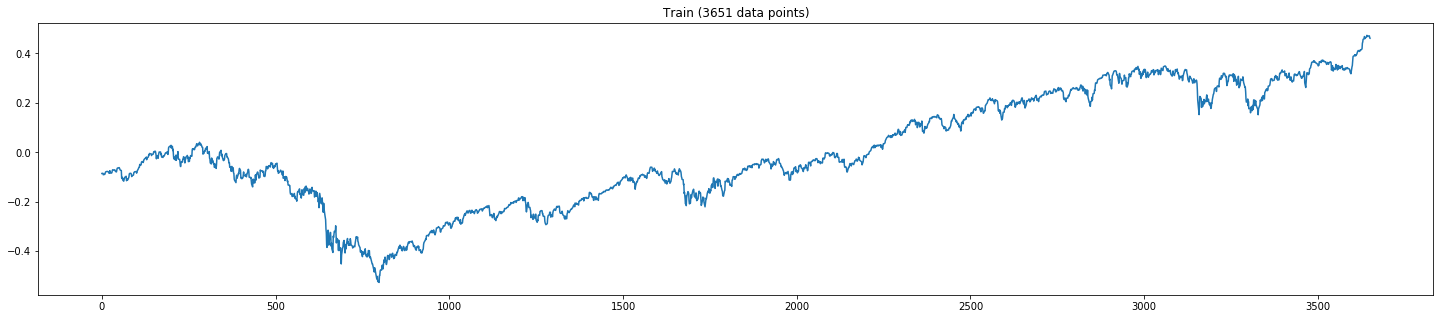

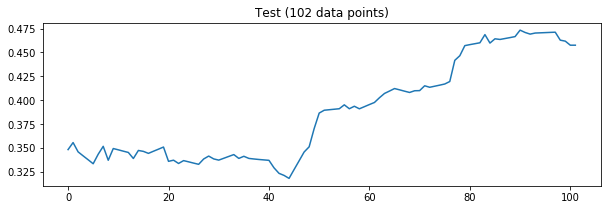

In [89]:
plt.figure(figsize=(25,5))
plt.plot(xTrain[:,0])
plt.title('Train (' +str(len(xTrain))+' data points)')
plt.show()
plt.figure(figsize=(10,3))
plt.plot(xTest[:,0])
plt.title('Test (' +str(len(xTest))+' data points)')
plt.show()

In [90]:
tf.reset_default_graph()

In [91]:
batchX_placeholder = tf.placeholder(dtype=tf.float32,shape=[None,truncated_backprop_length,num_features],name='data_ph')
batchY_placeholder = tf.placeholder(dtype=tf.float32,shape=[None,truncated_backprop_length,num_classes],name='target_ph')

** Weights and biases <br>
Because is a 3 layer net: <br>
Input <br>
Hidden Recurrent layer <br>
Output <br>
We need 2 pairs of W and b **

In [92]:
W2 = tf.Variable(initial_value=np.random.rand(state_size,num_classes),dtype=tf.float32)
b2 = tf.Variable(initial_value=np.random.rand(1,num_classes),dtype=tf.float32)

** Unpack **

In [93]:
labels_series = tf.unstack(batchY_placeholder, axis=1)

** Forward pass - Unroll the cell **

In [94]:
cell = tf.contrib.rnn.BasicLSTMCell(num_units=state_size)

states_series, current_state = tf.nn.dynamic_rnn(cell=cell,inputs=batchX_placeholder,dtype=tf.float32)

In [95]:
states_series = tf.transpose(states_series,[1,0,2])

** Backward pass - Output **

In [96]:
last_state = tf.gather(params=states_series,indices=states_series.get_shape()[0]-1)
last_label = tf.gather(params=labels_series,indices=len(labels_series)-1)

** Backward pass - Output **

In [97]:
weight = tf.Variable(tf.truncated_normal([state_size,num_classes]))
bias = tf.Variable(tf.constant(0.1,shape=[num_classes]))

** Backward pass - Output **

In [98]:
prediction = tf.matmul(last_state,weight) + bias
prediction

<tf.Tensor 'add:0' shape=(?, 1) dtype=float32>

In [99]:
loss = tf.reduce_mean(tf.squared_difference(last_label,prediction))

train_step = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [103]:
loss_list = []
test_pred_list = []

with tf.Session() as sess:
    
    tf.global_variables_initializer().run()
    
    for epoch_idx in range(num_epochs):
                
        print('Epoch %d' %epoch_idx)
        
        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length * batch_size
        
            
            batchX = xTrain[start_idx:end_idx,:].reshape(batch_size,truncated_backprop_length,num_features)
            batchY = yTrain[start_idx:end_idx].reshape(batch_size,truncated_backprop_length,1)
                
            #print('IDXs',start_idx,end_idx)
            #print('X',batchX.shape,batchX)
            #print('Y',batchX.shape,batchY)
            
            feed = {batchX_placeholder : batchX, batchY_placeholder : batchY}
            
            #TRAIN!
            _loss,_train_step,_pred,_last_label,_prediction = sess.run(
                fetches=[loss,train_step,prediction,last_label,prediction],
                feed_dict = feed
            )
            
            loss_list.append(_loss)
            
           
            
            if(batch_idx % 50 == 0):
                print('Step %d - Loss: %.6f' %(batch_idx,_loss))
                
    #TEST
    
    
    for test_idx in range(len(xTest) - truncated_backprop_length):
        
        testBatchX = xTest[test_idx:test_idx+truncated_backprop_length,:].reshape((1,truncated_backprop_length,num_features))        
        testBatchY = yTest[test_idx:test_idx+truncated_backprop_length].reshape((1,truncated_backprop_length,1))

        
        #_current_state = np.zeros((batch_size,state_size))
        feed = {batchX_placeholder : testBatchX,
            batchY_placeholder : testBatchY}

        #Test_pred contains 'window_size' predictions, we want the last one
        _last_state,_last_label,test_pred = sess.run([last_state,last_label,prediction],feed_dict=feed)
        test_pred_list.append(test_pred[-1][0]) #The last one

Epoch 0
Step 0 - Loss: 0.043662
Step 50 - Loss: 0.002383
Step 100 - Loss: 0.000141
Step 150 - Loss: 0.001843
Step 200 - Loss: 0.002385
Step 250 - Loss: 0.001161
Step 300 - Loss: 0.000230
Step 350 - Loss: 0.000000
Step 400 - Loss: 0.000007
Step 450 - Loss: 0.000007
Step 500 - Loss: 0.000342
Step 550 - Loss: 0.000296
Step 600 - Loss: 0.000008
Step 650 - Loss: 0.000054
Step 700 - Loss: 0.000317
Step 750 - Loss: 0.000087
Step 800 - Loss: 0.000149
Step 850 - Loss: 0.000103
Step 900 - Loss: 0.000000
Step 950 - Loss: 0.000006
Step 1000 - Loss: 0.000039
Step 1050 - Loss: 0.001310
Step 1100 - Loss: 0.003414
Step 1150 - Loss: 0.000020
Step 1200 - Loss: 0.001555
Epoch 1
Step 0 - Loss: 0.069849
Step 50 - Loss: 0.000007
Step 100 - Loss: 0.000076
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000049
Step 250 - Loss: 0.000169
Step 300 - Loss: 0.000264
Step 350 - Loss: 0.000023
Step 400 - Loss: 0.000000
Step 450 - Loss: 0.000007
Step 500 - Loss: 0.000042
Step 550 - Loss: 0.000013
Step 600 - Loss: 0.0000

Step 550 - Loss: 0.000019
Step 600 - Loss: 0.000031
Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000062
Step 750 - Loss: 0.000003
Step 800 - Loss: 0.000005
Step 850 - Loss: 0.000008
Step 900 - Loss: 0.000031
Step 950 - Loss: 0.000220
Step 1000 - Loss: 0.000005
Step 1050 - Loss: 0.000827
Step 1100 - Loss: 0.000003
Step 1150 - Loss: 0.000020
Step 1200 - Loss: 0.000010
Epoch 13
Step 0 - Loss: 0.005872
Step 50 - Loss: 0.000000
Step 100 - Loss: 0.000076
Step 150 - Loss: 0.000001
Step 200 - Loss: 0.000034
Step 250 - Loss: 0.000181
Step 300 - Loss: 0.000205
Step 350 - Loss: 0.000007
Step 400 - Loss: 0.000000
Step 450 - Loss: 0.000041
Step 500 - Loss: 0.000039
Step 550 - Loss: 0.000019
Step 600 - Loss: 0.000036
Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000064
Step 750 - Loss: 0.000003
Step 800 - Loss: 0.000005
Step 850 - Loss: 0.000008
Step 900 - Loss: 0.000030
Step 950 - Loss: 0.000215
Step 1000 - Loss: 0.000006
Step 1050 - Loss: 0.000809
Step 1100 - Loss: 0.000002
Step 1150 - Loss: 0.0000

Step 1100 - Loss: 0.000000
Step 1150 - Loss: 0.000009
Step 1200 - Loss: 0.000000
Epoch 25
Step 0 - Loss: 0.003363
Step 50 - Loss: 0.000001
Step 100 - Loss: 0.000146
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000028
Step 250 - Loss: 0.000194
Step 300 - Loss: 0.000133
Step 350 - Loss: 0.000000
Step 400 - Loss: 0.000003
Step 450 - Loss: 0.000027
Step 500 - Loss: 0.000028
Step 550 - Loss: 0.000011
Step 600 - Loss: 0.000144
Step 650 - Loss: 0.000001
Step 700 - Loss: 0.000062
Step 750 - Loss: 0.000002
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000008
Step 900 - Loss: 0.000021
Step 950 - Loss: 0.000135
Step 1000 - Loss: 0.000008
Step 1050 - Loss: 0.000669
Step 1100 - Loss: 0.000000
Step 1150 - Loss: 0.000007
Step 1200 - Loss: 0.000000
Epoch 26
Step 0 - Loss: 0.003245
Step 50 - Loss: 0.000001
Step 100 - Loss: 0.000150
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000029
Step 250 - Loss: 0.000192
Step 300 - Loss: 0.000128
Step 350 - Loss: 0.000000
Step 400 - Loss: 0.000003
Step 450 - Loss: 0

Step 400 - Loss: 0.000007
Step 450 - Loss: 0.000024
Step 500 - Loss: 0.000025
Step 550 - Loss: 0.000005
Step 600 - Loss: 0.000226
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000059
Step 750 - Loss: 0.000002
Step 800 - Loss: 0.000001
Step 850 - Loss: 0.000007
Step 900 - Loss: 0.000013
Step 950 - Loss: 0.000103
Step 1000 - Loss: 0.000009
Step 1050 - Loss: 0.000664
Step 1100 - Loss: 0.000000
Step 1150 - Loss: 0.000000
Step 1200 - Loss: 0.000000
Epoch 38
Step 0 - Loss: 0.002407
Step 50 - Loss: 0.000003
Step 100 - Loss: 0.000165
Step 150 - Loss: 0.000001
Step 200 - Loss: 0.000016
Step 250 - Loss: 0.000263
Step 300 - Loss: 0.000068
Step 350 - Loss: 0.000001
Step 400 - Loss: 0.000007
Step 450 - Loss: 0.000024
Step 500 - Loss: 0.000025
Step 550 - Loss: 0.000004
Step 600 - Loss: 0.000230
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000059
Step 750 - Loss: 0.000002
Step 800 - Loss: 0.000001
Step 850 - Loss: 0.000006
Step 900 - Loss: 0.000012
Step 950 - Loss: 0.000102
Step 1000 - Loss: 0.000009


Step 1000 - Loss: 0.000011
Step 1050 - Loss: 0.000655
Step 1100 - Loss: 0.000000
Step 1150 - Loss: 0.000000
Step 1200 - Loss: 0.000000
Epoch 50
Step 0 - Loss: 0.001629
Step 50 - Loss: 0.000007
Step 100 - Loss: 0.000167
Step 150 - Loss: 0.000001
Step 200 - Loss: 0.000009
Step 250 - Loss: 0.000392
Step 300 - Loss: 0.000031
Step 350 - Loss: 0.000001
Step 400 - Loss: 0.000011
Step 450 - Loss: 0.000025
Step 500 - Loss: 0.000022
Step 550 - Loss: 0.000001
Step 600 - Loss: 0.000280
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000054
Step 750 - Loss: 0.000005
Step 800 - Loss: 0.000000
Step 850 - Loss: 0.000004
Step 900 - Loss: 0.000008
Step 950 - Loss: 0.000103
Step 1000 - Loss: 0.000011
Step 1050 - Loss: 0.000653
Step 1100 - Loss: 0.000000
Step 1150 - Loss: 0.000000
Step 1200 - Loss: 0.000000
Epoch 51
Step 0 - Loss: 0.001566
Step 50 - Loss: 0.000007
Step 100 - Loss: 0.000168
Step 150 - Loss: 0.000001
Step 200 - Loss: 0.000008
Step 250 - Loss: 0.000404
Step 300 - Loss: 0.000029
Step 350 - Loss:

Step 300 - Loss: 0.000025
Step 350 - Loss: 0.000004
Step 400 - Loss: 0.000019
Step 450 - Loss: 0.000028
Step 500 - Loss: 0.000019
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000328
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000052
Step 750 - Loss: 0.000006
Step 800 - Loss: 0.000000
Step 850 - Loss: 0.000003
Step 900 - Loss: 0.000007
Step 950 - Loss: 0.000114
Step 1000 - Loss: 0.000010
Step 1050 - Loss: 0.000634
Step 1100 - Loss: 0.000002
Step 1150 - Loss: 0.000001
Step 1200 - Loss: 0.000000
Epoch 63
Step 0 - Loss: 0.000928
Step 50 - Loss: 0.000011
Step 100 - Loss: 0.000176
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000004
Step 250 - Loss: 0.000544
Step 300 - Loss: 0.000026
Step 350 - Loss: 0.000004
Step 400 - Loss: 0.000020
Step 450 - Loss: 0.000029
Step 500 - Loss: 0.000019
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000331
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000052
Step 750 - Loss: 0.000006
Step 800 - Loss: 0.000001
Step 850 - Loss: 0.000003
Step 900 - Loss: 0.000007
S

Step 900 - Loss: 0.000007
Step 950 - Loss: 0.000125
Step 1000 - Loss: 0.000008
Step 1050 - Loss: 0.000628
Step 1100 - Loss: 0.000006
Step 1150 - Loss: 0.000002
Step 1200 - Loss: 0.000002
Epoch 75
Step 0 - Loss: 0.000565
Step 50 - Loss: 0.000013
Step 100 - Loss: 0.000185
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000001
Step 250 - Loss: 0.000561
Step 300 - Loss: 0.000063
Step 350 - Loss: 0.000006
Step 400 - Loss: 0.000032
Step 450 - Loss: 0.000036
Step 500 - Loss: 0.000015
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000369
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000052
Step 750 - Loss: 0.000005
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000003
Step 900 - Loss: 0.000007
Step 950 - Loss: 0.000126
Step 1000 - Loss: 0.000008
Step 1050 - Loss: 0.000628
Step 1100 - Loss: 0.000007
Step 1150 - Loss: 0.000002
Step 1200 - Loss: 0.000002
Epoch 76
Step 0 - Loss: 0.000546
Step 50 - Loss: 0.000013
Step 100 - Loss: 0.000186
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000001
Step 250 - Loss:

Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000000
Step 250 - Loss: 0.000479
Step 300 - Loss: 0.000118
Step 350 - Loss: 0.000004
Step 400 - Loss: 0.000039
Step 450 - Loss: 0.000042
Step 500 - Loss: 0.000012
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000394
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000052
Step 750 - Loss: 0.000004
Step 800 - Loss: 0.000003
Step 850 - Loss: 0.000003
Step 900 - Loss: 0.000008
Step 950 - Loss: 0.000135
Step 1000 - Loss: 0.000006
Step 1050 - Loss: 0.000633
Step 1100 - Loss: 0.000010
Step 1150 - Loss: 0.000003
Step 1200 - Loss: 0.000004
Epoch 88
Step 0 - Loss: 0.000405
Step 50 - Loss: 0.000014
Step 100 - Loss: 0.000190
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000000
Step 250 - Loss: 0.000471
Step 300 - Loss: 0.000122
Step 350 - Loss: 0.000004
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000042
Step 500 - Loss: 0.000012
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000395
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000052
Step 750 - Loss: 0.000004
S

Step 750 - Loss: 0.000003
Step 800 - Loss: 0.000003
Step 850 - Loss: 0.000004
Step 900 - Loss: 0.000008
Step 950 - Loss: 0.000142
Step 1000 - Loss: 0.000005
Step 1050 - Loss: 0.000644
Step 1100 - Loss: 0.000013
Step 1150 - Loss: 0.000004
Step 1200 - Loss: 0.000006
Epoch 100
Step 0 - Loss: 0.000347
Step 50 - Loss: 0.000015
Step 100 - Loss: 0.000191
Step 150 - Loss: 0.000003
Step 200 - Loss: 0.000000
Step 250 - Loss: 0.000383
Step 300 - Loss: 0.000159
Step 350 - Loss: 0.000002
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000045
Step 500 - Loss: 0.000011
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000412
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000053
Step 750 - Loss: 0.000003
Step 800 - Loss: 0.000003
Step 850 - Loss: 0.000004
Step 900 - Loss: 0.000008
Step 950 - Loss: 0.000142
Step 1000 - Loss: 0.000005
Step 1050 - Loss: 0.000645
Step 1100 - Loss: 0.000014
Step 1150 - Loss: 0.000004
Step 1200 - Loss: 0.000007
Epoch 101
Step 0 - Loss: 0.000344
Step 50 - Loss: 0.000015
Step 100 - Los

Step 50 - Loss: 0.000016
Step 100 - Loss: 0.000191
Step 150 - Loss: 0.000003
Step 200 - Loss: 0.000000
Step 250 - Loss: 0.000313
Step 300 - Loss: 0.000177
Step 350 - Loss: 0.000001
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000046
Step 500 - Loss: 0.000010
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000425
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000053
Step 750 - Loss: 0.000003
Step 800 - Loss: 0.000004
Step 850 - Loss: 0.000004
Step 900 - Loss: 0.000009
Step 950 - Loss: 0.000149
Step 1000 - Loss: 0.000004
Step 1050 - Loss: 0.000659
Step 1100 - Loss: 0.000016
Step 1150 - Loss: 0.000005
Step 1200 - Loss: 0.000010
Epoch 113
Step 0 - Loss: 0.000314
Step 50 - Loss: 0.000016
Step 100 - Loss: 0.000191
Step 150 - Loss: 0.000003
Step 200 - Loss: 0.000000
Step 250 - Loss: 0.000308
Step 300 - Loss: 0.000178
Step 350 - Loss: 0.000001
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000046
Step 500 - Loss: 0.000010
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000425
Step 650 - Loss: 0.000000
S

Step 600 - Loss: 0.000434
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000053
Step 750 - Loss: 0.000003
Step 800 - Loss: 0.000004
Step 850 - Loss: 0.000004
Step 900 - Loss: 0.000010
Step 950 - Loss: 0.000155
Step 1000 - Loss: 0.000004
Step 1050 - Loss: 0.000674
Step 1100 - Loss: 0.000019
Step 1150 - Loss: 0.000006
Step 1200 - Loss: 0.000013
Epoch 125
Step 0 - Loss: 0.000292
Step 50 - Loss: 0.000016
Step 100 - Loss: 0.000190
Step 150 - Loss: 0.000003
Step 200 - Loss: 0.000000
Step 250 - Loss: 0.000255
Step 300 - Loss: 0.000184
Step 350 - Loss: 0.000000
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000047
Step 500 - Loss: 0.000010
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000435
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000053
Step 750 - Loss: 0.000003
Step 800 - Loss: 0.000004
Step 850 - Loss: 0.000004
Step 900 - Loss: 0.000010
Step 950 - Loss: 0.000155
Step 1000 - Loss: 0.000004
Step 1050 - Loss: 0.000675
Step 1100 - Loss: 0.000019
Step 1150 - Loss: 0.000006
Step 1200 - Loss: 0.00

Step 1100 - Loss: 0.000023
Step 1150 - Loss: 0.000007
Step 1200 - Loss: 0.000017
Epoch 137
Step 0 - Loss: 0.000272
Step 50 - Loss: 0.000016
Step 100 - Loss: 0.000189
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000000
Step 250 - Loss: 0.000215
Step 300 - Loss: 0.000185
Step 350 - Loss: 0.000000
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000047
Step 500 - Loss: 0.000010
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000441
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000053
Step 750 - Loss: 0.000003
Step 800 - Loss: 0.000004
Step 850 - Loss: 0.000005
Step 900 - Loss: 0.000011
Step 950 - Loss: 0.000161
Step 1000 - Loss: 0.000003
Step 1050 - Loss: 0.000689
Step 1100 - Loss: 0.000023
Step 1150 - Loss: 0.000007
Step 1200 - Loss: 0.000017
Epoch 138
Step 0 - Loss: 0.000270
Step 50 - Loss: 0.000016
Step 100 - Loss: 0.000189
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000000
Step 250 - Loss: 0.000212
Step 300 - Loss: 0.000185
Step 350 - Loss: 0.000000
Step 400 - Loss: 0.000042
Step 450 - Loss:

Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000047
Step 500 - Loss: 0.000010
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000446
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000054
Step 750 - Loss: 0.000003
Step 800 - Loss: 0.000003
Step 850 - Loss: 0.000005
Step 900 - Loss: 0.000012
Step 950 - Loss: 0.000166
Step 1000 - Loss: 0.000003
Step 1050 - Loss: 0.000701
Step 1100 - Loss: 0.000028
Step 1150 - Loss: 0.000008
Step 1200 - Loss: 0.000020
Epoch 150
Step 0 - Loss: 0.000253
Step 50 - Loss: 0.000015
Step 100 - Loss: 0.000188
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000000
Step 250 - Loss: 0.000181
Step 300 - Loss: 0.000183
Step 350 - Loss: 0.000000
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000047
Step 500 - Loss: 0.000010
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000446
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000054
Step 750 - Loss: 0.000003
Step 800 - Loss: 0.000003
Step 850 - Loss: 0.000005
Step 900 - Loss: 0.000012
Step 950 - Loss: 0.000167
Step 1000 - Loss: 0.000003

Step 950 - Loss: 0.000170
Step 1000 - Loss: 0.000002
Step 1050 - Loss: 0.000713
Step 1100 - Loss: 0.000034
Step 1150 - Loss: 0.000009
Step 1200 - Loss: 0.000023
Epoch 162
Step 0 - Loss: 0.000239
Step 50 - Loss: 0.000014
Step 100 - Loss: 0.000187
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000000
Step 250 - Loss: 0.000156
Step 300 - Loss: 0.000179
Step 350 - Loss: 0.000001
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000047
Step 500 - Loss: 0.000009
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000449
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000054
Step 750 - Loss: 0.000003
Step 800 - Loss: 0.000003
Step 850 - Loss: 0.000006
Step 900 - Loss: 0.000013
Step 950 - Loss: 0.000170
Step 1000 - Loss: 0.000002
Step 1050 - Loss: 0.000714
Step 1100 - Loss: 0.000034
Step 1150 - Loss: 0.000009
Step 1200 - Loss: 0.000023
Epoch 163
Step 0 - Loss: 0.000238
Step 50 - Loss: 0.000014
Step 100 - Loss: 0.000186
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000000
Step 250 - Loss: 0.000154
Step 300 - Los

Step 200 - Loss: 0.000000
Step 250 - Loss: 0.000137
Step 300 - Loss: 0.000170
Step 350 - Loss: 0.000002
Step 400 - Loss: 0.000038
Step 450 - Loss: 0.000047
Step 500 - Loss: 0.000009
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000451
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000054
Step 750 - Loss: 0.000003
Step 800 - Loss: 0.000003
Step 850 - Loss: 0.000006
Step 900 - Loss: 0.000013
Step 950 - Loss: 0.000171
Step 1000 - Loss: 0.000002
Step 1050 - Loss: 0.000725
Step 1100 - Loss: 0.000040
Step 1150 - Loss: 0.000010
Step 1200 - Loss: 0.000027
Epoch 175
Step 0 - Loss: 0.000228
Step 50 - Loss: 0.000013
Step 100 - Loss: 0.000185
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000000
Step 250 - Loss: 0.000135
Step 300 - Loss: 0.000169
Step 350 - Loss: 0.000002
Step 400 - Loss: 0.000038
Step 450 - Loss: 0.000047
Step 500 - Loss: 0.000009
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000451
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000054
Step 750 - Loss: 0.000003
Step 800 - Loss: 0.000002


Step 750 - Loss: 0.000002
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000007
Step 900 - Loss: 0.000014
Step 950 - Loss: 0.000171
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000733
Step 1100 - Loss: 0.000044
Step 1150 - Loss: 0.000011
Step 1200 - Loss: 0.000031
Epoch 187
Step 0 - Loss: 0.000221
Step 50 - Loss: 0.000012
Step 100 - Loss: 0.000183
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000000
Step 250 - Loss: 0.000122
Step 300 - Loss: 0.000155
Step 350 - Loss: 0.000004
Step 400 - Loss: 0.000037
Step 450 - Loss: 0.000047
Step 500 - Loss: 0.000009
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000453
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000054
Step 750 - Loss: 0.000002
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000007
Step 900 - Loss: 0.000014
Step 950 - Loss: 0.000171
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000733
Step 1100 - Loss: 0.000045
Step 1150 - Loss: 0.000011
Step 1200 - Loss: 0.000031
Epoch 188
Step 0 - Loss: 0.000221
Step 50 - Loss: 0.000012
Step 100 - Los

Step 100 - Loss: 0.000182
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000000
Step 250 - Loss: 0.000111
Step 300 - Loss: 0.000139
Step 350 - Loss: 0.000006
Step 400 - Loss: 0.000036
Step 450 - Loss: 0.000048
Step 500 - Loss: 0.000009
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000455
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000054
Step 750 - Loss: 0.000002
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000007
Step 900 - Loss: 0.000014
Step 950 - Loss: 0.000170
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000739
Step 1100 - Loss: 0.000048
Step 1150 - Loss: 0.000011
Step 1200 - Loss: 0.000037
Epoch 200
Step 0 - Loss: 0.000218
Step 50 - Loss: 0.000011
Step 100 - Loss: 0.000182
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000000
Step 250 - Loss: 0.000110
Step 300 - Loss: 0.000138
Step 350 - Loss: 0.000006
Step 400 - Loss: 0.000036
Step 450 - Loss: 0.000048
Step 500 - Loss: 0.000009
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000455
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000054


Step 600 - Loss: 0.000456
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000054
Step 750 - Loss: 0.000002
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000008
Step 900 - Loss: 0.000015
Step 950 - Loss: 0.000170
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000744
Step 1100 - Loss: 0.000049
Step 1150 - Loss: 0.000012
Step 1200 - Loss: 0.000044
Epoch 212
Step 0 - Loss: 0.000216
Step 50 - Loss: 0.000011
Step 100 - Loss: 0.000182
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000000
Step 250 - Loss: 0.000100
Step 300 - Loss: 0.000120
Step 350 - Loss: 0.000008
Step 400 - Loss: 0.000036
Step 450 - Loss: 0.000049
Step 500 - Loss: 0.000008
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000456
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000054
Step 750 - Loss: 0.000002
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000008
Step 900 - Loss: 0.000015
Step 950 - Loss: 0.000170
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000745
Step 1100 - Loss: 0.000049
Step 1150 - Loss: 0.000012
Step 1200 - Loss: 0.00

Step 1100 - Loss: 0.000049
Step 1150 - Loss: 0.000012
Step 1200 - Loss: 0.000053
Epoch 224
Step 0 - Loss: 0.000213
Step 50 - Loss: 0.000011
Step 100 - Loss: 0.000182
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000000
Step 250 - Loss: 0.000090
Step 300 - Loss: 0.000104
Step 350 - Loss: 0.000009
Step 400 - Loss: 0.000037
Step 450 - Loss: 0.000050
Step 500 - Loss: 0.000008
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000456
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000056
Step 750 - Loss: 0.000002
Step 800 - Loss: 0.000001
Step 850 - Loss: 0.000008
Step 900 - Loss: 0.000015
Step 950 - Loss: 0.000170
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000749
Step 1100 - Loss: 0.000049
Step 1150 - Loss: 0.000012
Step 1200 - Loss: 0.000054
Epoch 225
Step 0 - Loss: 0.000213
Step 50 - Loss: 0.000011
Step 100 - Loss: 0.000182
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000000
Step 250 - Loss: 0.000089
Step 300 - Loss: 0.000102
Step 350 - Loss: 0.000009
Step 400 - Loss: 0.000037
Step 450 - Loss:

Step 350 - Loss: 0.000010
Step 400 - Loss: 0.000038
Step 450 - Loss: 0.000051
Step 500 - Loss: 0.000007
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000457
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000058
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000009
Step 900 - Loss: 0.000015
Step 950 - Loss: 0.000172
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000754
Step 1100 - Loss: 0.000049
Step 1150 - Loss: 0.000012
Step 1200 - Loss: 0.000063
Epoch 237
Step 0 - Loss: 0.000208
Step 50 - Loss: 0.000011
Step 100 - Loss: 0.000182
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000000
Step 250 - Loss: 0.000077
Step 300 - Loss: 0.000088
Step 350 - Loss: 0.000010
Step 400 - Loss: 0.000038
Step 450 - Loss: 0.000051
Step 500 - Loss: 0.000007
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000457
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000058
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000009
Step 900 - Loss: 0.000015
Step 950 - Loss: 0.000172


Step 850 - Loss: 0.000010
Step 900 - Loss: 0.000015
Step 950 - Loss: 0.000174
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000758
Step 1100 - Loss: 0.000047
Step 1150 - Loss: 0.000012
Step 1200 - Loss: 0.000072
Epoch 249
Step 0 - Loss: 0.000200
Step 50 - Loss: 0.000011
Step 100 - Loss: 0.000183
Step 150 - Loss: 0.000001
Step 200 - Loss: 0.000001
Step 250 - Loss: 0.000065
Step 300 - Loss: 0.000076
Step 350 - Loss: 0.000011
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000052
Step 500 - Loss: 0.000007
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000458
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000060
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000010
Step 900 - Loss: 0.000015
Step 950 - Loss: 0.000174
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000758
Step 1100 - Loss: 0.000047
Step 1150 - Loss: 0.000012
Step 1200 - Loss: 0.000073
Epoch 250
Step 0 - Loss: 0.000200
Step 50 - Loss: 0.000011
Step 100 - Loss: 0.000183
Step 150 - Loss: 0.000001
Step 200 - Los

Step 150 - Loss: 0.000001
Step 200 - Loss: 0.000002
Step 250 - Loss: 0.000054
Step 300 - Loss: 0.000065
Step 350 - Loss: 0.000011
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000052
Step 500 - Loss: 0.000007
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000459
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000063
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000010
Step 900 - Loss: 0.000015
Step 950 - Loss: 0.000178
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000761
Step 1100 - Loss: 0.000046
Step 1150 - Loss: 0.000011
Step 1200 - Loss: 0.000081
Epoch 262
Step 0 - Loss: 0.000190
Step 50 - Loss: 0.000011
Step 100 - Loss: 0.000183
Step 150 - Loss: 0.000001
Step 200 - Loss: 0.000002
Step 250 - Loss: 0.000053
Step 300 - Loss: 0.000064
Step 350 - Loss: 0.000011
Step 400 - Loss: 0.000042
Step 450 - Loss: 0.000052
Step 500 - Loss: 0.000007
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000459
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000064
Step 750 - Loss: 0.000001


Step 700 - Loss: 0.000066
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000010
Step 900 - Loss: 0.000015
Step 950 - Loss: 0.000181
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000763
Step 1100 - Loss: 0.000045
Step 1150 - Loss: 0.000010
Step 1200 - Loss: 0.000087
Epoch 274
Step 0 - Loss: 0.000179
Step 50 - Loss: 0.000011
Step 100 - Loss: 0.000183
Step 150 - Loss: 0.000001
Step 200 - Loss: 0.000002
Step 250 - Loss: 0.000043
Step 300 - Loss: 0.000054
Step 350 - Loss: 0.000011
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000052
Step 500 - Loss: 0.000006
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000459
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000066
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000010
Step 900 - Loss: 0.000015
Step 950 - Loss: 0.000181
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000763
Step 1100 - Loss: 0.000044
Step 1150 - Loss: 0.000010
Step 1200 - Loss: 0.000088
Epoch 275
Step 0 - Loss: 0.000178
Step 50 - Los

Step 1200 - Loss: 0.000091
Epoch 286
Step 0 - Loss: 0.000168
Step 50 - Loss: 0.000011
Step 100 - Loss: 0.000183
Step 150 - Loss: 0.000001
Step 200 - Loss: 0.000003
Step 250 - Loss: 0.000035
Step 300 - Loss: 0.000046
Step 350 - Loss: 0.000011
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000053
Step 500 - Loss: 0.000006
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000459
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000069
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000002
Step 850 - Loss: 0.000010
Step 900 - Loss: 0.000015
Step 950 - Loss: 0.000185
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000762
Step 1100 - Loss: 0.000043
Step 1150 - Loss: 0.000009
Step 1200 - Loss: 0.000092
Epoch 287
Step 0 - Loss: 0.000167
Step 50 - Loss: 0.000011
Step 100 - Loss: 0.000183
Step 150 - Loss: 0.000001
Step 200 - Loss: 0.000004
Step 250 - Loss: 0.000035
Step 300 - Loss: 0.000045
Step 350 - Loss: 0.000011
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000053
Step 500 - Loss: 0.000006
Step 550 - Loss: 0

Step 500 - Loss: 0.000006
Step 550 - Loss: 0.000001
Step 600 - Loss: 0.000458
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000071
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000003
Step 850 - Loss: 0.000011
Step 900 - Loss: 0.000015
Step 950 - Loss: 0.000187
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000759
Step 1100 - Loss: 0.000043
Step 1150 - Loss: 0.000008
Step 1200 - Loss: 0.000094
Epoch 299
Step 0 - Loss: 0.000158
Step 50 - Loss: 0.000011
Step 100 - Loss: 0.000183
Step 150 - Loss: 0.000001
Step 200 - Loss: 0.000005
Step 250 - Loss: 0.000029
Step 300 - Loss: 0.000038
Step 350 - Loss: 0.000012
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000054
Step 500 - Loss: 0.000006
Step 550 - Loss: 0.000001
Step 600 - Loss: 0.000457
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000072
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000003
Step 850 - Loss: 0.000011
Step 900 - Loss: 0.000015
Step 950 - Loss: 0.000187
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000759
Step 1100 - Loss: 0.0000

Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000755
Step 1100 - Loss: 0.000042
Step 1150 - Loss: 0.000006
Step 1200 - Loss: 0.000094
Epoch 311
Step 0 - Loss: 0.000150
Step 50 - Loss: 0.000011
Step 100 - Loss: 0.000182
Step 150 - Loss: 0.000001
Step 200 - Loss: 0.000006
Step 250 - Loss: 0.000025
Step 300 - Loss: 0.000034
Step 350 - Loss: 0.000012
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000054
Step 500 - Loss: 0.000006
Step 550 - Loss: 0.000002
Step 600 - Loss: 0.000455
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000074
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000003
Step 850 - Loss: 0.000011
Step 900 - Loss: 0.000015
Step 950 - Loss: 0.000190
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000754
Step 1100 - Loss: 0.000042
Step 1150 - Loss: 0.000006
Step 1200 - Loss: 0.000094
Epoch 312
Step 0 - Loss: 0.000149
Step 50 - Loss: 0.000011
Step 100 - Loss: 0.000182
Step 150 - Loss: 0.000001
Step 200 - Loss: 0.000006
Step 250 - Loss: 0.000025
Step 300 - Loss: 0.000033
Step 350 - Los

Step 250 - Loss: 0.000022
Step 300 - Loss: 0.000031
Step 350 - Loss: 0.000013
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000056
Step 500 - Loss: 0.000006
Step 550 - Loss: 0.000003
Step 600 - Loss: 0.000452
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000075
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000003
Step 850 - Loss: 0.000011
Step 900 - Loss: 0.000015
Step 950 - Loss: 0.000191
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000749
Step 1100 - Loss: 0.000042
Step 1150 - Loss: 0.000005
Step 1200 - Loss: 0.000093
Epoch 324
Step 0 - Loss: 0.000143
Step 50 - Loss: 0.000011
Step 100 - Loss: 0.000181
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000008
Step 250 - Loss: 0.000022
Step 300 - Loss: 0.000031
Step 350 - Loss: 0.000013
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000056
Step 500 - Loss: 0.000006
Step 550 - Loss: 0.000003
Step 600 - Loss: 0.000451
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000076
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000003
Step 850 - Loss: 0.000011


Step 800 - Loss: 0.000003
Step 850 - Loss: 0.000012
Step 900 - Loss: 0.000015
Step 950 - Loss: 0.000192
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000743
Step 1100 - Loss: 0.000042
Step 1150 - Loss: 0.000003
Step 1200 - Loss: 0.000092
Epoch 336
Step 0 - Loss: 0.000140
Step 50 - Loss: 0.000010
Step 100 - Loss: 0.000180
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000009
Step 250 - Loss: 0.000021
Step 300 - Loss: 0.000030
Step 350 - Loss: 0.000014
Step 400 - Loss: 0.000047
Step 450 - Loss: 0.000057
Step 500 - Loss: 0.000006
Step 550 - Loss: 0.000006
Step 600 - Loss: 0.000447
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000077
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000003
Step 850 - Loss: 0.000012
Step 900 - Loss: 0.000015
Step 950 - Loss: 0.000192
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000743
Step 1100 - Loss: 0.000042
Step 1150 - Loss: 0.000003
Step 1200 - Loss: 0.000091
Epoch 337
Step 0 - Loss: 0.000139
Step 50 - Loss: 0.000010
Step 100 - Loss: 0.000180
Step 150 - Los

Step 100 - Loss: 0.000178
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000011
Step 250 - Loss: 0.000020
Step 300 - Loss: 0.000030
Step 350 - Loss: 0.000015
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000058
Step 500 - Loss: 0.000006
Step 550 - Loss: 0.000008
Step 600 - Loss: 0.000441
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000079
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000004
Step 850 - Loss: 0.000013
Step 900 - Loss: 0.000016
Step 950 - Loss: 0.000193
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000736
Step 1100 - Loss: 0.000042
Step 1150 - Loss: 0.000002
Step 1200 - Loss: 0.000088
Epoch 349
Step 0 - Loss: 0.000138
Step 50 - Loss: 0.000009
Step 100 - Loss: 0.000178
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000011
Step 250 - Loss: 0.000020
Step 300 - Loss: 0.000030
Step 350 - Loss: 0.000015
Step 400 - Loss: 0.000046
Step 450 - Loss: 0.000058
Step 500 - Loss: 0.000006
Step 550 - Loss: 0.000009
Step 600 - Loss: 0.000440
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000079


Step 600 - Loss: 0.000434
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000081
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000004
Step 850 - Loss: 0.000013
Step 900 - Loss: 0.000016
Step 950 - Loss: 0.000193
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000729
Step 1100 - Loss: 0.000042
Step 1150 - Loss: 0.000002
Step 1200 - Loss: 0.000083
Epoch 361
Step 0 - Loss: 0.000138
Step 50 - Loss: 0.000009
Step 100 - Loss: 0.000176
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000013
Step 250 - Loss: 0.000019
Step 300 - Loss: 0.000029
Step 350 - Loss: 0.000017
Step 400 - Loss: 0.000045
Step 450 - Loss: 0.000059
Step 500 - Loss: 0.000007
Step 550 - Loss: 0.000012
Step 600 - Loss: 0.000433
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000081
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000004
Step 850 - Loss: 0.000013
Step 900 - Loss: 0.000016
Step 950 - Loss: 0.000193
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000728
Step 1100 - Loss: 0.000042
Step 1150 - Loss: 0.000002
Step 1200 - Loss: 0.00

Step 1100 - Loss: 0.000042
Step 1150 - Loss: 0.000001
Step 1200 - Loss: 0.000077
Epoch 373
Step 0 - Loss: 0.000140
Step 50 - Loss: 0.000008
Step 100 - Loss: 0.000173
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000014
Step 250 - Loss: 0.000019
Step 300 - Loss: 0.000026
Step 350 - Loss: 0.000020
Step 400 - Loss: 0.000043
Step 450 - Loss: 0.000059
Step 500 - Loss: 0.000008
Step 550 - Loss: 0.000015
Step 600 - Loss: 0.000425
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000083
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000004
Step 850 - Loss: 0.000014
Step 900 - Loss: 0.000016
Step 950 - Loss: 0.000193
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000720
Step 1100 - Loss: 0.000042
Step 1150 - Loss: 0.000001
Step 1200 - Loss: 0.000076
Epoch 374
Step 0 - Loss: 0.000141
Step 50 - Loss: 0.000007
Step 100 - Loss: 0.000173
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000015
Step 250 - Loss: 0.000019
Step 300 - Loss: 0.000026
Step 350 - Loss: 0.000020
Step 400 - Loss: 0.000043
Step 450 - Loss:

Step 350 - Loss: 0.000023
Step 400 - Loss: 0.000041
Step 450 - Loss: 0.000058
Step 500 - Loss: 0.000009
Step 550 - Loss: 0.000018
Step 600 - Loss: 0.000415
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000085
Step 750 - Loss: 0.000002
Step 800 - Loss: 0.000004
Step 850 - Loss: 0.000015
Step 900 - Loss: 0.000017
Step 950 - Loss: 0.000193
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000712
Step 1100 - Loss: 0.000043
Step 1150 - Loss: 0.000001
Step 1200 - Loss: 0.000069
Epoch 386
Step 0 - Loss: 0.000144
Step 50 - Loss: 0.000007
Step 100 - Loss: 0.000170
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000016
Step 250 - Loss: 0.000019
Step 300 - Loss: 0.000022
Step 350 - Loss: 0.000023
Step 400 - Loss: 0.000040
Step 450 - Loss: 0.000058
Step 500 - Loss: 0.000009
Step 550 - Loss: 0.000018
Step 600 - Loss: 0.000415
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000085
Step 750 - Loss: 0.000002
Step 800 - Loss: 0.000004
Step 850 - Loss: 0.000015
Step 900 - Loss: 0.000017
Step 950 - Loss: 0.000193


Step 850 - Loss: 0.000015
Step 900 - Loss: 0.000017
Step 950 - Loss: 0.000193
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000703
Step 1100 - Loss: 0.000044
Step 1150 - Loss: 0.000001
Step 1200 - Loss: 0.000061
Epoch 398
Step 0 - Loss: 0.000147
Step 50 - Loss: 0.000006
Step 100 - Loss: 0.000167
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000017
Step 250 - Loss: 0.000018
Step 300 - Loss: 0.000018
Step 350 - Loss: 0.000027
Step 400 - Loss: 0.000038
Step 450 - Loss: 0.000056
Step 500 - Loss: 0.000010
Step 550 - Loss: 0.000019
Step 600 - Loss: 0.000405
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000087
Step 750 - Loss: 0.000002
Step 800 - Loss: 0.000004
Step 850 - Loss: 0.000015
Step 900 - Loss: 0.000017
Step 950 - Loss: 0.000193
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000702
Step 1100 - Loss: 0.000044
Step 1150 - Loss: 0.000001
Step 1200 - Loss: 0.000061
Epoch 399
Step 0 - Loss: 0.000148
Step 50 - Loss: 0.000006
Step 100 - Loss: 0.000167
Step 150 - Loss: 0.000002
Step 200 - Los

Step 150 - Loss: 0.000003
Step 200 - Loss: 0.000017
Step 250 - Loss: 0.000017
Step 300 - Loss: 0.000015
Step 350 - Loss: 0.000031
Step 400 - Loss: 0.000035
Step 450 - Loss: 0.000053
Step 500 - Loss: 0.000011
Step 550 - Loss: 0.000019
Step 600 - Loss: 0.000395
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000090
Step 750 - Loss: 0.000002
Step 800 - Loss: 0.000005
Step 850 - Loss: 0.000016
Step 900 - Loss: 0.000017
Step 950 - Loss: 0.000192
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000693
Step 1100 - Loss: 0.000044
Step 1150 - Loss: 0.000000
Step 1200 - Loss: 0.000054
Epoch 411
Step 0 - Loss: 0.000151
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000164
Step 150 - Loss: 0.000003
Step 200 - Loss: 0.000018
Step 250 - Loss: 0.000017
Step 300 - Loss: 0.000014
Step 350 - Loss: 0.000031
Step 400 - Loss: 0.000035
Step 450 - Loss: 0.000053
Step 500 - Loss: 0.000011
Step 550 - Loss: 0.000019
Step 600 - Loss: 0.000394
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000090
Step 750 - Loss: 0.000002


Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000093
Step 750 - Loss: 0.000002
Step 800 - Loss: 0.000005
Step 850 - Loss: 0.000016
Step 900 - Loss: 0.000018
Step 950 - Loss: 0.000192
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000685
Step 1100 - Loss: 0.000044
Step 1150 - Loss: 0.000000
Step 1200 - Loss: 0.000048
Epoch 423
Step 0 - Loss: 0.000155
Step 50 - Loss: 0.000004
Step 100 - Loss: 0.000161
Step 150 - Loss: 0.000003
Step 200 - Loss: 0.000018
Step 250 - Loss: 0.000015
Step 300 - Loss: 0.000011
Step 350 - Loss: 0.000036
Step 400 - Loss: 0.000032
Step 450 - Loss: 0.000050
Step 500 - Loss: 0.000012
Step 550 - Loss: 0.000018
Step 600 - Loss: 0.000384
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000093
Step 750 - Loss: 0.000002
Step 800 - Loss: 0.000005
Step 850 - Loss: 0.000016
Step 900 - Loss: 0.000018
Step 950 - Loss: 0.000191
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000684
Step 1100 - Loss: 0.000044
Step 1150 - Loss: 0.000000
Step 1200 - Loss: 0.000048
Epoch 424
Step 0 - Lo

Step 1200 - Loss: 0.000044
Epoch 435
Step 0 - Loss: 0.000160
Step 50 - Loss: 0.000004
Step 100 - Loss: 0.000159
Step 150 - Loss: 0.000003
Step 200 - Loss: 0.000019
Step 250 - Loss: 0.000012
Step 300 - Loss: 0.000008
Step 350 - Loss: 0.000041
Step 400 - Loss: 0.000030
Step 450 - Loss: 0.000047
Step 500 - Loss: 0.000013
Step 550 - Loss: 0.000016
Step 600 - Loss: 0.000374
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000096
Step 750 - Loss: 0.000002
Step 800 - Loss: 0.000005
Step 850 - Loss: 0.000017
Step 900 - Loss: 0.000018
Step 950 - Loss: 0.000191
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000677
Step 1100 - Loss: 0.000044
Step 1150 - Loss: 0.000000
Step 1200 - Loss: 0.000043
Epoch 436
Step 0 - Loss: 0.000160
Step 50 - Loss: 0.000004
Step 100 - Loss: 0.000159
Step 150 - Loss: 0.000003
Step 200 - Loss: 0.000019
Step 250 - Loss: 0.000012
Step 300 - Loss: 0.000008
Step 350 - Loss: 0.000042
Step 400 - Loss: 0.000030
Step 450 - Loss: 0.000047
Step 500 - Loss: 0.000013
Step 550 - Loss: 0

Step 500 - Loss: 0.000014
Step 550 - Loss: 0.000014
Step 600 - Loss: 0.000364
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000098
Step 750 - Loss: 0.000002
Step 800 - Loss: 0.000006
Step 850 - Loss: 0.000017
Step 900 - Loss: 0.000018
Step 950 - Loss: 0.000190
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000670
Step 1100 - Loss: 0.000044
Step 1150 - Loss: 0.000000
Step 1200 - Loss: 0.000039
Epoch 448
Step 0 - Loss: 0.000164
Step 50 - Loss: 0.000003
Step 100 - Loss: 0.000156
Step 150 - Loss: 0.000003
Step 200 - Loss: 0.000020
Step 250 - Loss: 0.000009
Step 300 - Loss: 0.000005
Step 350 - Loss: 0.000048
Step 400 - Loss: 0.000027
Step 450 - Loss: 0.000043
Step 500 - Loss: 0.000014
Step 550 - Loss: 0.000014
Step 600 - Loss: 0.000363
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000099
Step 750 - Loss: 0.000002
Step 800 - Loss: 0.000006
Step 850 - Loss: 0.000017
Step 900 - Loss: 0.000019
Step 950 - Loss: 0.000190
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000669
Step 1100 - Loss: 0.0000

Step 1050 - Loss: 0.000663
Step 1100 - Loss: 0.000044
Step 1150 - Loss: 0.000000
Step 1200 - Loss: 0.000036
Epoch 460
Step 0 - Loss: 0.000167
Step 50 - Loss: 0.000003
Step 100 - Loss: 0.000154
Step 150 - Loss: 0.000003
Step 200 - Loss: 0.000020
Step 250 - Loss: 0.000006
Step 300 - Loss: 0.000003
Step 350 - Loss: 0.000054
Step 400 - Loss: 0.000025
Step 450 - Loss: 0.000040
Step 500 - Loss: 0.000014
Step 550 - Loss: 0.000011
Step 600 - Loss: 0.000351
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000101
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000006
Step 850 - Loss: 0.000017
Step 900 - Loss: 0.000019
Step 950 - Loss: 0.000188
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000662
Step 1100 - Loss: 0.000044
Step 1150 - Loss: 0.000000
Step 1200 - Loss: 0.000036
Epoch 461
Step 0 - Loss: 0.000167
Step 50 - Loss: 0.000003
Step 100 - Loss: 0.000154
Step 150 - Loss: 0.000003
Step 200 - Loss: 0.000020
Step 250 - Loss: 0.000006
Step 300 - Loss: 0.000003
Step 350 - Loss: 0.000054
Step 400 - Loss

Step 300 - Loss: 0.000003
Step 350 - Loss: 0.000059
Step 400 - Loss: 0.000023
Step 450 - Loss: 0.000036
Step 500 - Loss: 0.000014
Step 550 - Loss: 0.000009
Step 600 - Loss: 0.000339
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000103
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000007
Step 850 - Loss: 0.000018
Step 900 - Loss: 0.000019
Step 950 - Loss: 0.000187
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000655
Step 1100 - Loss: 0.000044
Step 1150 - Loss: 0.000000
Step 1200 - Loss: 0.000032
Epoch 473
Step 0 - Loss: 0.000169
Step 50 - Loss: 0.000002
Step 100 - Loss: 0.000151
Step 150 - Loss: 0.000003
Step 200 - Loss: 0.000020
Step 250 - Loss: 0.000003
Step 300 - Loss: 0.000003
Step 350 - Loss: 0.000060
Step 400 - Loss: 0.000023
Step 450 - Loss: 0.000036
Step 500 - Loss: 0.000014
Step 550 - Loss: 0.000009
Step 600 - Loss: 0.000338
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000103
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000007
Step 850 - Loss: 0.000018
Step 900 - Loss: 0.000019


Step 850 - Loss: 0.000018
Step 900 - Loss: 0.000020
Step 950 - Loss: 0.000185
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000647
Step 1100 - Loss: 0.000044
Step 1150 - Loss: 0.000000
Step 1200 - Loss: 0.000029
Epoch 485
Step 0 - Loss: 0.000168
Step 50 - Loss: 0.000002
Step 100 - Loss: 0.000149
Step 150 - Loss: 0.000003
Step 200 - Loss: 0.000020
Step 250 - Loss: 0.000001
Step 300 - Loss: 0.000003
Step 350 - Loss: 0.000064
Step 400 - Loss: 0.000022
Step 450 - Loss: 0.000032
Step 500 - Loss: 0.000014
Step 550 - Loss: 0.000007
Step 600 - Loss: 0.000325
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000104
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000007
Step 850 - Loss: 0.000018
Step 900 - Loss: 0.000020
Step 950 - Loss: 0.000185
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000646
Step 1100 - Loss: 0.000044
Step 1150 - Loss: 0.000000
Step 1200 - Loss: 0.000028
Epoch 486
Step 0 - Loss: 0.000168
Step 50 - Loss: 0.000002
Step 100 - Loss: 0.000149
Step 150 - Loss: 0.000003
Step 200 - Los

Step 100 - Loss: 0.000147
Step 150 - Loss: 0.000003
Step 200 - Loss: 0.000020
Step 250 - Loss: 0.000000
Step 300 - Loss: 0.000004
Step 350 - Loss: 0.000066
Step 400 - Loss: 0.000021
Step 450 - Loss: 0.000029
Step 500 - Loss: 0.000014
Step 550 - Loss: 0.000006
Step 600 - Loss: 0.000311
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000105
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000008
Step 850 - Loss: 0.000017
Step 900 - Loss: 0.000021
Step 950 - Loss: 0.000184
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000638
Step 1100 - Loss: 0.000044
Step 1150 - Loss: 0.000000
Step 1200 - Loss: 0.000025
Epoch 498
Step 0 - Loss: 0.000166
Step 50 - Loss: 0.000002
Step 100 - Loss: 0.000147
Step 150 - Loss: 0.000003
Step 200 - Loss: 0.000020
Step 250 - Loss: 0.000000
Step 300 - Loss: 0.000004
Step 350 - Loss: 0.000066
Step 400 - Loss: 0.000021
Step 450 - Loss: 0.000028
Step 500 - Loss: 0.000014
Step 550 - Loss: 0.000005
Step 600 - Loss: 0.000310
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000105


Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000106
Step 750 - Loss: 0.000000
Step 800 - Loss: 0.000008
Step 850 - Loss: 0.000017
Step 900 - Loss: 0.000021
Step 950 - Loss: 0.000183
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000629
Step 1100 - Loss: 0.000043
Step 1150 - Loss: 0.000001
Step 1200 - Loss: 0.000021
Epoch 510
Step 0 - Loss: 0.000160
Step 50 - Loss: 0.000002
Step 100 - Loss: 0.000146
Step 150 - Loss: 0.000004
Step 200 - Loss: 0.000020
Step 250 - Loss: 0.000001
Step 300 - Loss: 0.000006
Step 350 - Loss: 0.000066
Step 400 - Loss: 0.000020
Step 450 - Loss: 0.000025
Step 500 - Loss: 0.000014
Step 550 - Loss: 0.000004
Step 600 - Loss: 0.000298
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000106
Step 750 - Loss: 0.000000
Step 800 - Loss: 0.000008
Step 850 - Loss: 0.000017
Step 900 - Loss: 0.000021
Step 950 - Loss: 0.000183
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000628
Step 1100 - Loss: 0.000043
Step 1150 - Loss: 0.000001
Step 1200 - Loss: 0.000020
Epoch 511
Step 0 - Lo

Step 1200 - Loss: 0.000017
Epoch 522
Step 0 - Loss: 0.000151
Step 50 - Loss: 0.000002
Step 100 - Loss: 0.000146
Step 150 - Loss: 0.000004
Step 200 - Loss: 0.000021
Step 250 - Loss: 0.000003
Step 300 - Loss: 0.000010
Step 350 - Loss: 0.000065
Step 400 - Loss: 0.000020
Step 450 - Loss: 0.000022
Step 500 - Loss: 0.000014
Step 550 - Loss: 0.000004
Step 600 - Loss: 0.000286
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000107
Step 750 - Loss: 0.000000
Step 800 - Loss: 0.000008
Step 850 - Loss: 0.000017
Step 900 - Loss: 0.000022
Step 950 - Loss: 0.000182
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000618
Step 1100 - Loss: 0.000043
Step 1150 - Loss: 0.000002
Step 1200 - Loss: 0.000016
Epoch 523
Step 0 - Loss: 0.000150
Step 50 - Loss: 0.000002
Step 100 - Loss: 0.000146
Step 150 - Loss: 0.000004
Step 200 - Loss: 0.000021
Step 250 - Loss: 0.000004
Step 300 - Loss: 0.000010
Step 350 - Loss: 0.000065
Step 400 - Loss: 0.000020
Step 450 - Loss: 0.000022
Step 500 - Loss: 0.000014
Step 550 - Loss: 0

Step 450 - Loss: 0.000020
Step 500 - Loss: 0.000014
Step 550 - Loss: 0.000003
Step 600 - Loss: 0.000277
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000108
Step 750 - Loss: 0.000000
Step 800 - Loss: 0.000009
Step 850 - Loss: 0.000016
Step 900 - Loss: 0.000022
Step 950 - Loss: 0.000181
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000607
Step 1100 - Loss: 0.000043
Step 1150 - Loss: 0.000003
Step 1200 - Loss: 0.000012
Epoch 535
Step 0 - Loss: 0.000138
Step 50 - Loss: 0.000002
Step 100 - Loss: 0.000148
Step 150 - Loss: 0.000004
Step 200 - Loss: 0.000022
Step 250 - Loss: 0.000008
Step 300 - Loss: 0.000015
Step 350 - Loss: 0.000064
Step 400 - Loss: 0.000020
Step 450 - Loss: 0.000019
Step 500 - Loss: 0.000014
Step 550 - Loss: 0.000003
Step 600 - Loss: 0.000277
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000108
Step 750 - Loss: 0.000000
Step 800 - Loss: 0.000009
Step 850 - Loss: 0.000016
Step 900 - Loss: 0.000022
Step 950 - Loss: 0.000181
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.00060

Step 900 - Loss: 0.000023
Step 950 - Loss: 0.000179
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000596
Step 1100 - Loss: 0.000043
Step 1150 - Loss: 0.000004
Step 1200 - Loss: 0.000009
Epoch 547
Step 0 - Loss: 0.000125
Step 50 - Loss: 0.000002
Step 100 - Loss: 0.000149
Step 150 - Loss: 0.000003
Step 200 - Loss: 0.000023
Step 250 - Loss: 0.000012
Step 300 - Loss: 0.000020
Step 350 - Loss: 0.000064
Step 400 - Loss: 0.000019
Step 450 - Loss: 0.000017
Step 500 - Loss: 0.000013
Step 550 - Loss: 0.000003
Step 600 - Loss: 0.000270
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000109
Step 750 - Loss: 0.000000
Step 800 - Loss: 0.000009
Step 850 - Loss: 0.000016
Step 900 - Loss: 0.000023
Step 950 - Loss: 0.000179
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000595
Step 1100 - Loss: 0.000043
Step 1150 - Loss: 0.000004
Step 1200 - Loss: 0.000008
Epoch 548
Step 0 - Loss: 0.000123
Step 50 - Loss: 0.000003
Step 100 - Loss: 0.000150
Step 150 - Loss: 0.000003
Step 200 - Loss: 0.000024
Step 250 - Los

Step 150 - Loss: 0.000003
Step 200 - Loss: 0.000025
Step 250 - Loss: 0.000017
Step 300 - Loss: 0.000027
Step 350 - Loss: 0.000065
Step 400 - Loss: 0.000019
Step 450 - Loss: 0.000015
Step 500 - Loss: 0.000014
Step 550 - Loss: 0.000003
Step 600 - Loss: 0.000265
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000110
Step 750 - Loss: 0.000000
Step 800 - Loss: 0.000009
Step 850 - Loss: 0.000015
Step 900 - Loss: 0.000023
Step 950 - Loss: 0.000177
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000583
Step 1100 - Loss: 0.000043
Step 1150 - Loss: 0.000006
Step 1200 - Loss: 0.000005
Epoch 560
Step 0 - Loss: 0.000109
Step 50 - Loss: 0.000003
Step 100 - Loss: 0.000152
Step 150 - Loss: 0.000003
Step 200 - Loss: 0.000026
Step 250 - Loss: 0.000017
Step 300 - Loss: 0.000027
Step 350 - Loss: 0.000065
Step 400 - Loss: 0.000019
Step 450 - Loss: 0.000015
Step 500 - Loss: 0.000014
Step 550 - Loss: 0.000002
Step 600 - Loss: 0.000265
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000110
Step 750 - Loss: 0.000000


Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000110
Step 750 - Loss: 0.000000
Step 800 - Loss: 0.000008
Step 850 - Loss: 0.000015
Step 900 - Loss: 0.000023
Step 950 - Loss: 0.000175
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000570
Step 1100 - Loss: 0.000044
Step 1150 - Loss: 0.000007
Step 1200 - Loss: 0.000003
Epoch 572
Step 0 - Loss: 0.000096
Step 50 - Loss: 0.000003
Step 100 - Loss: 0.000154
Step 150 - Loss: 0.000003
Step 200 - Loss: 0.000028
Step 250 - Loss: 0.000022
Step 300 - Loss: 0.000032
Step 350 - Loss: 0.000069
Step 400 - Loss: 0.000018
Step 450 - Loss: 0.000014
Step 500 - Loss: 0.000014
Step 550 - Loss: 0.000002
Step 600 - Loss: 0.000263
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000110
Step 750 - Loss: 0.000000
Step 800 - Loss: 0.000008
Step 850 - Loss: 0.000015
Step 900 - Loss: 0.000023
Step 950 - Loss: 0.000174
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000569
Step 1100 - Loss: 0.000044
Step 1150 - Loss: 0.000007
Step 1200 - Loss: 0.000002
Epoch 573
Step 0 - Lo

Step 1150 - Loss: 0.000007
Step 1200 - Loss: 0.000001
Epoch 584
Step 0 - Loss: 0.000085
Step 50 - Loss: 0.000003
Step 100 - Loss: 0.000157
Step 150 - Loss: 0.000003
Step 200 - Loss: 0.000030
Step 250 - Loss: 0.000027
Step 300 - Loss: 0.000033
Step 350 - Loss: 0.000075
Step 400 - Loss: 0.000018
Step 450 - Loss: 0.000013
Step 500 - Loss: 0.000014
Step 550 - Loss: 0.000001
Step 600 - Loss: 0.000262
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000110
Step 750 - Loss: 0.000000
Step 800 - Loss: 0.000008
Step 850 - Loss: 0.000014
Step 900 - Loss: 0.000024
Step 950 - Loss: 0.000171
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000556
Step 1100 - Loss: 0.000045
Step 1150 - Loss: 0.000007
Step 1200 - Loss: 0.000001
Epoch 585
Step 0 - Loss: 0.000084
Step 50 - Loss: 0.000003
Step 100 - Loss: 0.000157
Step 150 - Loss: 0.000003
Step 200 - Loss: 0.000030
Step 250 - Loss: 0.000027
Step 300 - Loss: 0.000033
Step 350 - Loss: 0.000075
Step 400 - Loss: 0.000018
Step 450 - Loss: 0.000013
Step 500 - Loss: 

Step 450 - Loss: 0.000012
Step 500 - Loss: 0.000015
Step 550 - Loss: 0.000001
Step 600 - Loss: 0.000263
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000109
Step 750 - Loss: 0.000000
Step 800 - Loss: 0.000008
Step 850 - Loss: 0.000014
Step 900 - Loss: 0.000024
Step 950 - Loss: 0.000167
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000543
Step 1100 - Loss: 0.000046
Step 1150 - Loss: 0.000007
Step 1200 - Loss: 0.000000
Epoch 597
Step 0 - Loss: 0.000077
Step 50 - Loss: 0.000003
Step 100 - Loss: 0.000159
Step 150 - Loss: 0.000003
Step 200 - Loss: 0.000031
Step 250 - Loss: 0.000031
Step 300 - Loss: 0.000030
Step 350 - Loss: 0.000084
Step 400 - Loss: 0.000017
Step 450 - Loss: 0.000012
Step 500 - Loss: 0.000015
Step 550 - Loss: 0.000001
Step 600 - Loss: 0.000264
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000109
Step 750 - Loss: 0.000000
Step 800 - Loss: 0.000008
Step 850 - Loss: 0.000014
Step 900 - Loss: 0.000024
Step 950 - Loss: 0.000167
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.00054

Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000530
Step 1100 - Loss: 0.000047
Step 1150 - Loss: 0.000007
Step 1200 - Loss: 0.000000
Epoch 609
Step 0 - Loss: 0.000072
Step 50 - Loss: 0.000003
Step 100 - Loss: 0.000160
Step 150 - Loss: 0.000003
Step 200 - Loss: 0.000032
Step 250 - Loss: 0.000034
Step 300 - Loss: 0.000025
Step 350 - Loss: 0.000096
Step 400 - Loss: 0.000017
Step 450 - Loss: 0.000012
Step 500 - Loss: 0.000015
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000265
Step 650 - Loss: 0.000000
Step 700 - Loss: 0.000109
Step 750 - Loss: 0.000000
Step 800 - Loss: 0.000008
Step 850 - Loss: 0.000013
Step 900 - Loss: 0.000025
Step 950 - Loss: 0.000162
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000529
Step 1100 - Loss: 0.000047
Step 1150 - Loss: 0.000006
Step 1200 - Loss: 0.000000
Epoch 610
Step 0 - Loss: 0.000072
Step 50 - Loss: 0.000003
Step 100 - Loss: 0.000161
Step 150 - Loss: 0.000003
Step 200 - Loss: 0.000032
Step 250 - Loss: 0.000034
Step 300 - Loss: 0.000024
Step 350 - Los

Step 250 - Loss: 0.000035
Step 300 - Loss: 0.000019
Step 350 - Loss: 0.000109
Step 400 - Loss: 0.000017
Step 450 - Loss: 0.000012
Step 500 - Loss: 0.000016
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000267
Step 650 - Loss: 0.000001
Step 700 - Loss: 0.000107
Step 750 - Loss: 0.000000
Step 800 - Loss: 0.000008
Step 850 - Loss: 0.000013
Step 900 - Loss: 0.000026
Step 950 - Loss: 0.000156
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000517
Step 1100 - Loss: 0.000048
Step 1150 - Loss: 0.000005
Step 1200 - Loss: 0.000000
Epoch 622
Step 0 - Loss: 0.000071
Step 50 - Loss: 0.000003
Step 100 - Loss: 0.000161
Step 150 - Loss: 0.000003
Step 200 - Loss: 0.000033
Step 250 - Loss: 0.000035
Step 300 - Loss: 0.000018
Step 350 - Loss: 0.000111
Step 400 - Loss: 0.000017
Step 450 - Loss: 0.000012
Step 500 - Loss: 0.000016
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000268
Step 650 - Loss: 0.000001
Step 700 - Loss: 0.000107
Step 750 - Loss: 0.000000
Step 800 - Loss: 0.000008
Step 850 - Loss: 0.000013


Step 750 - Loss: 0.000000
Step 800 - Loss: 0.000007
Step 850 - Loss: 0.000012
Step 900 - Loss: 0.000027
Step 950 - Loss: 0.000149
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000507
Step 1100 - Loss: 0.000048
Step 1150 - Loss: 0.000004
Step 1200 - Loss: 0.000000
Epoch 634
Step 0 - Loss: 0.000071
Step 50 - Loss: 0.000003
Step 100 - Loss: 0.000162
Step 150 - Loss: 0.000003
Step 200 - Loss: 0.000035
Step 250 - Loss: 0.000033
Step 300 - Loss: 0.000013
Step 350 - Loss: 0.000125
Step 400 - Loss: 0.000018
Step 450 - Loss: 0.000013
Step 500 - Loss: 0.000017
Step 550 - Loss: 0.000000
Step 600 - Loss: 0.000270
Step 650 - Loss: 0.000001
Step 700 - Loss: 0.000106
Step 750 - Loss: 0.000000
Step 800 - Loss: 0.000007
Step 850 - Loss: 0.000012
Step 900 - Loss: 0.000027
Step 950 - Loss: 0.000149
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000506
Step 1100 - Loss: 0.000048
Step 1150 - Loss: 0.000004
Step 1200 - Loss: 0.000001
Epoch 635
Step 0 - Loss: 0.000071
Step 50 - Loss: 0.000003
Step 100 - Los

Step 50 - Loss: 0.000004
Step 100 - Loss: 0.000162
Step 150 - Loss: 0.000003
Step 200 - Loss: 0.000036
Step 250 - Loss: 0.000028
Step 300 - Loss: 0.000009
Step 350 - Loss: 0.000140
Step 400 - Loss: 0.000018
Step 450 - Loss: 0.000014
Step 500 - Loss: 0.000018
Step 550 - Loss: 0.000001
Step 600 - Loss: 0.000272
Step 650 - Loss: 0.000001
Step 700 - Loss: 0.000105
Step 750 - Loss: 0.000000
Step 800 - Loss: 0.000007
Step 850 - Loss: 0.000012
Step 900 - Loss: 0.000028
Step 950 - Loss: 0.000142
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000498
Step 1100 - Loss: 0.000048
Step 1150 - Loss: 0.000004
Step 1200 - Loss: 0.000001
Epoch 647
Step 0 - Loss: 0.000074
Step 50 - Loss: 0.000004
Step 100 - Loss: 0.000162
Step 150 - Loss: 0.000003
Step 200 - Loss: 0.000036
Step 250 - Loss: 0.000028
Step 300 - Loss: 0.000009
Step 350 - Loss: 0.000142
Step 400 - Loss: 0.000018
Step 450 - Loss: 0.000014
Step 500 - Loss: 0.000018
Step 550 - Loss: 0.000001
Step 600 - Loss: 0.000272
Step 650 - Loss: 0.000001
S

Step 600 - Loss: 0.000275
Step 650 - Loss: 0.000001
Step 700 - Loss: 0.000104
Step 750 - Loss: 0.000000
Step 800 - Loss: 0.000006
Step 850 - Loss: 0.000011
Step 900 - Loss: 0.000029
Step 950 - Loss: 0.000136
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000492
Step 1100 - Loss: 0.000047
Step 1150 - Loss: 0.000003
Step 1200 - Loss: 0.000001
Epoch 659
Step 0 - Loss: 0.000077
Step 50 - Loss: 0.000004
Step 100 - Loss: 0.000161
Step 150 - Loss: 0.000003
Step 200 - Loss: 0.000038
Step 250 - Loss: 0.000022
Step 300 - Loss: 0.000007
Step 350 - Loss: 0.000155
Step 400 - Loss: 0.000019
Step 450 - Loss: 0.000016
Step 500 - Loss: 0.000020
Step 550 - Loss: 0.000002
Step 600 - Loss: 0.000275
Step 650 - Loss: 0.000001
Step 700 - Loss: 0.000103
Step 750 - Loss: 0.000000
Step 800 - Loss: 0.000006
Step 850 - Loss: 0.000011
Step 900 - Loss: 0.000029
Step 950 - Loss: 0.000135
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000492
Step 1100 - Loss: 0.000047
Step 1150 - Loss: 0.000003
Step 1200 - Loss: 0.00

Step 1100 - Loss: 0.000047
Step 1150 - Loss: 0.000003
Step 1200 - Loss: 0.000001
Epoch 671
Step 0 - Loss: 0.000081
Step 50 - Loss: 0.000004
Step 100 - Loss: 0.000160
Step 150 - Loss: 0.000003
Step 200 - Loss: 0.000039
Step 250 - Loss: 0.000016
Step 300 - Loss: 0.000007
Step 350 - Loss: 0.000167
Step 400 - Loss: 0.000019
Step 450 - Loss: 0.000017
Step 500 - Loss: 0.000022
Step 550 - Loss: 0.000003
Step 600 - Loss: 0.000278
Step 650 - Loss: 0.000001
Step 700 - Loss: 0.000102
Step 750 - Loss: 0.000000
Step 800 - Loss: 0.000006
Step 850 - Loss: 0.000011
Step 900 - Loss: 0.000030
Step 950 - Loss: 0.000129
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000488
Step 1100 - Loss: 0.000047
Step 1150 - Loss: 0.000003
Step 1200 - Loss: 0.000001
Epoch 672
Step 0 - Loss: 0.000081
Step 50 - Loss: 0.000004
Step 100 - Loss: 0.000160
Step 150 - Loss: 0.000003
Step 200 - Loss: 0.000039
Step 250 - Loss: 0.000015
Step 300 - Loss: 0.000007
Step 350 - Loss: 0.000168
Step 400 - Loss: 0.000019
Step 450 - Loss:

Step 400 - Loss: 0.000020
Step 450 - Loss: 0.000018
Step 500 - Loss: 0.000023
Step 550 - Loss: 0.000005
Step 600 - Loss: 0.000280
Step 650 - Loss: 0.000001
Step 700 - Loss: 0.000101
Step 750 - Loss: 0.000000
Step 800 - Loss: 0.000005
Step 850 - Loss: 0.000011
Step 900 - Loss: 0.000031
Step 950 - Loss: 0.000124
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000486
Step 1100 - Loss: 0.000046
Step 1150 - Loss: 0.000003
Step 1200 - Loss: 0.000000
Epoch 684
Step 0 - Loss: 0.000084
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000159
Step 150 - Loss: 0.000003
Step 200 - Loss: 0.000040
Step 250 - Loss: 0.000011
Step 300 - Loss: 0.000008
Step 350 - Loss: 0.000178
Step 400 - Loss: 0.000020
Step 450 - Loss: 0.000018
Step 500 - Loss: 0.000023
Step 550 - Loss: 0.000005
Step 600 - Loss: 0.000280
Step 650 - Loss: 0.000001
Step 700 - Loss: 0.000101
Step 750 - Loss: 0.000000
Step 800 - Loss: 0.000005
Step 850 - Loss: 0.000011
Step 900 - Loss: 0.000031
Step 950 - Loss: 0.000124
Step 1000 - Loss: 0.000001

Step 950 - Loss: 0.000119
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000485
Step 1100 - Loss: 0.000046
Step 1150 - Loss: 0.000003
Step 1200 - Loss: 0.000000
Epoch 696
Step 0 - Loss: 0.000086
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000157
Step 150 - Loss: 0.000003
Step 200 - Loss: 0.000040
Step 250 - Loss: 0.000008
Step 300 - Loss: 0.000010
Step 350 - Loss: 0.000184
Step 400 - Loss: 0.000020
Step 450 - Loss: 0.000018
Step 500 - Loss: 0.000025
Step 550 - Loss: 0.000007
Step 600 - Loss: 0.000282
Step 650 - Loss: 0.000001
Step 700 - Loss: 0.000099
Step 750 - Loss: 0.000000
Step 800 - Loss: 0.000005
Step 850 - Loss: 0.000010
Step 900 - Loss: 0.000032
Step 950 - Loss: 0.000119
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000485
Step 1100 - Loss: 0.000046
Step 1150 - Loss: 0.000003
Step 1200 - Loss: 0.000000
Epoch 697
Step 0 - Loss: 0.000086
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000157
Step 150 - Loss: 0.000003
Step 200 - Loss: 0.000040
Step 250 - Loss: 0.000008
Step 300 - Los

Step 200 - Loss: 0.000040
Step 250 - Loss: 0.000006
Step 300 - Loss: 0.000011
Step 350 - Loss: 0.000189
Step 400 - Loss: 0.000020
Step 450 - Loss: 0.000019
Step 500 - Loss: 0.000027
Step 550 - Loss: 0.000008
Step 600 - Loss: 0.000283
Step 650 - Loss: 0.000001
Step 700 - Loss: 0.000097
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000005
Step 850 - Loss: 0.000010
Step 900 - Loss: 0.000033
Step 950 - Loss: 0.000115
Step 1000 - Loss: 0.000002
Step 1050 - Loss: 0.000485
Step 1100 - Loss: 0.000044
Step 1150 - Loss: 0.000003
Step 1200 - Loss: 0.000000
Epoch 709
Step 0 - Loss: 0.000087
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000155
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000040
Step 250 - Loss: 0.000006
Step 300 - Loss: 0.000012
Step 350 - Loss: 0.000189
Step 400 - Loss: 0.000020
Step 450 - Loss: 0.000019
Step 500 - Loss: 0.000027
Step 550 - Loss: 0.000008
Step 600 - Loss: 0.000283
Step 650 - Loss: 0.000001
Step 700 - Loss: 0.000097
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000005


Step 700 - Loss: 0.000096
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000005
Step 850 - Loss: 0.000010
Step 900 - Loss: 0.000033
Step 950 - Loss: 0.000111
Step 1000 - Loss: 0.000002
Step 1050 - Loss: 0.000485
Step 1100 - Loss: 0.000043
Step 1150 - Loss: 0.000003
Step 1200 - Loss: 0.000000
Epoch 721
Step 0 - Loss: 0.000087
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000153
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000040
Step 250 - Loss: 0.000005
Step 300 - Loss: 0.000013
Step 350 - Loss: 0.000191
Step 400 - Loss: 0.000020
Step 450 - Loss: 0.000019
Step 500 - Loss: 0.000029
Step 550 - Loss: 0.000008
Step 600 - Loss: 0.000283
Step 650 - Loss: 0.000002
Step 700 - Loss: 0.000096
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000005
Step 850 - Loss: 0.000010
Step 900 - Loss: 0.000033
Step 950 - Loss: 0.000111
Step 1000 - Loss: 0.000002
Step 1050 - Loss: 0.000484
Step 1100 - Loss: 0.000043
Step 1150 - Loss: 0.000003
Step 1200 - Loss: 0.000000
Epoch 722
Step 0 - Loss: 0.000087
Step 50 - Los

Step 1200 - Loss: 0.000000
Epoch 733
Step 0 - Loss: 0.000089
Step 50 - Loss: 0.000006
Step 100 - Loss: 0.000150
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000039
Step 250 - Loss: 0.000004
Step 300 - Loss: 0.000048
Step 350 - Loss: 0.000190
Step 400 - Loss: 0.000022
Step 450 - Loss: 0.000022
Step 500 - Loss: 0.000030
Step 550 - Loss: 0.000009
Step 600 - Loss: 0.000286
Step 650 - Loss: 0.000002
Step 700 - Loss: 0.000093
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000004
Step 850 - Loss: 0.000010
Step 900 - Loss: 0.000034
Step 950 - Loss: 0.000108
Step 1000 - Loss: 0.000002
Step 1050 - Loss: 0.000483
Step 1100 - Loss: 0.000041
Step 1150 - Loss: 0.000003
Step 1200 - Loss: 0.000000
Epoch 734
Step 0 - Loss: 0.000082
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000151
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000040
Step 250 - Loss: 0.000004
Step 300 - Loss: 0.000000
Step 350 - Loss: 0.000193
Step 400 - Loss: 0.000020
Step 450 - Loss: 0.000019
Step 500 - Loss: 0.000030
Step 550 - Loss: 0

Step 500 - Loss: 0.000032
Step 550 - Loss: 0.000009
Step 600 - Loss: 0.000288
Step 650 - Loss: 0.000002
Step 700 - Loss: 0.000091
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000004
Step 850 - Loss: 0.000010
Step 900 - Loss: 0.000033
Step 950 - Loss: 0.000105
Step 1000 - Loss: 0.000002
Step 1050 - Loss: 0.000482
Step 1100 - Loss: 0.000039
Step 1150 - Loss: 0.000003
Step 1200 - Loss: 0.000000
Epoch 746
Step 0 - Loss: 0.000081
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000149
Step 150 - Loss: 0.000001
Step 200 - Loss: 0.000039
Step 250 - Loss: 0.000003
Step 300 - Loss: 0.000001
Step 350 - Loss: 0.000191
Step 400 - Loss: 0.000020
Step 450 - Loss: 0.000019
Step 500 - Loss: 0.000032
Step 550 - Loss: 0.000005
Step 600 - Loss: 0.000282
Step 650 - Loss: 0.000002
Step 700 - Loss: 0.000092
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000005
Step 850 - Loss: 0.000009
Step 900 - Loss: 0.000033
Step 950 - Loss: 0.000104
Step 1000 - Loss: 0.000003
Step 1050 - Loss: 0.000485
Step 1100 - Loss: 0.0000

Step 1000 - Loss: 0.000003
Step 1050 - Loss: 0.000482
Step 1100 - Loss: 0.000037
Step 1150 - Loss: 0.000004
Step 1200 - Loss: 0.000000
Epoch 758
Step 0 - Loss: 0.000086
Step 50 - Loss: 0.000006
Step 100 - Loss: 0.000145
Step 150 - Loss: 0.000001
Step 200 - Loss: 0.000038
Step 250 - Loss: 0.000002
Step 300 - Loss: 0.000002
Step 350 - Loss: 0.000181
Step 400 - Loss: 0.000019
Step 450 - Loss: 0.000018
Step 500 - Loss: 0.000032
Step 550 - Loss: 0.000003
Step 600 - Loss: 0.000279
Step 650 - Loss: 0.000002
Step 700 - Loss: 0.000091
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000005
Step 850 - Loss: 0.000009
Step 900 - Loss: 0.000033
Step 950 - Loss: 0.000103
Step 1000 - Loss: 0.000003
Step 1050 - Loss: 0.000483
Step 1100 - Loss: 0.000035
Step 1150 - Loss: 0.000004
Step 1200 - Loss: 0.000000
Epoch 759
Step 0 - Loss: 0.000090
Step 50 - Loss: 0.000006
Step 100 - Loss: 0.000143
Step 150 - Loss: 0.000001
Step 200 - Loss: 0.000035
Step 250 - Loss: 0.000002
Step 300 - Loss: 0.000049
Step 350 - Los

Step 250 - Loss: 0.000001
Step 300 - Loss: 0.000017
Step 350 - Loss: 0.000192
Step 400 - Loss: 0.000023
Step 450 - Loss: 0.000024
Step 500 - Loss: 0.000036
Step 550 - Loss: 0.000006
Step 600 - Loss: 0.000287
Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000086
Step 750 - Loss: 0.000002
Step 800 - Loss: 0.000005
Step 850 - Loss: 0.000009
Step 900 - Loss: 0.000032
Step 950 - Loss: 0.000098
Step 1000 - Loss: 0.000003
Step 1050 - Loss: 0.000480
Step 1100 - Loss: 0.000034
Step 1150 - Loss: 0.000004
Step 1200 - Loss: 0.000000
Epoch 771
Step 0 - Loss: 0.000083
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000143
Step 150 - Loss: 0.000001
Step 200 - Loss: 0.000038
Step 250 - Loss: 0.000000
Step 300 - Loss: 0.000012
Step 350 - Loss: 0.000178
Step 400 - Loss: 0.000020
Step 450 - Loss: 0.000019
Step 500 - Loss: 0.000035
Step 550 - Loss: 0.000004
Step 600 - Loss: 0.000280
Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000088
Step 750 - Loss: 0.000002
Step 800 - Loss: 0.000005
Step 850 - Loss: 0.000009


Step 750 - Loss: 0.000002
Step 800 - Loss: 0.000005
Step 850 - Loss: 0.000010
Step 900 - Loss: 0.000032
Step 950 - Loss: 0.000095
Step 1000 - Loss: 0.000003
Step 1050 - Loss: 0.000477
Step 1100 - Loss: 0.000031
Step 1150 - Loss: 0.000004
Step 1200 - Loss: 0.000000
Epoch 783
Step 0 - Loss: 0.000080
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000141
Step 150 - Loss: 0.000000
Step 200 - Loss: 0.000036
Step 250 - Loss: 0.000001
Step 300 - Loss: 0.000037
Step 350 - Loss: 0.000200
Step 400 - Loss: 0.000024
Step 450 - Loss: 0.000026
Step 500 - Loss: 0.000038
Step 550 - Loss: 0.000005
Step 600 - Loss: 0.000291
Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000084
Step 750 - Loss: 0.000002
Step 800 - Loss: 0.000005
Step 850 - Loss: 0.000010
Step 900 - Loss: 0.000032
Step 950 - Loss: 0.000096
Step 1000 - Loss: 0.000004
Step 1050 - Loss: 0.000477
Step 1100 - Loss: 0.000032
Step 1150 - Loss: 0.000004
Step 1200 - Loss: 0.000000
Epoch 784
Step 0 - Loss: 0.000081
Step 50 - Loss: 0.000005
Step 100 - Los

Step 50 - Loss: 0.000006
Step 100 - Loss: 0.000139
Step 150 - Loss: 0.000000
Step 200 - Loss: 0.000033
Step 250 - Loss: 0.000004
Step 300 - Loss: 0.000000
Step 350 - Loss: 0.000221
Step 400 - Loss: 0.000021
Step 450 - Loss: 0.000026
Step 500 - Loss: 0.000038
Step 550 - Loss: 0.000003
Step 600 - Loss: 0.000288
Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000085
Step 750 - Loss: 0.000002
Step 800 - Loss: 0.000005
Step 850 - Loss: 0.000010
Step 900 - Loss: 0.000031
Step 950 - Loss: 0.000092
Step 1000 - Loss: 0.000003
Step 1050 - Loss: 0.000476
Step 1100 - Loss: 0.000029
Step 1150 - Loss: 0.000003
Step 1200 - Loss: 0.000001
Epoch 796
Step 0 - Loss: 0.000079
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000140
Step 150 - Loss: 0.000000
Step 200 - Loss: 0.000036
Step 250 - Loss: 0.000001
Step 300 - Loss: 0.000040
Step 350 - Loss: 0.000211
Step 400 - Loss: 0.000023
Step 450 - Loss: 0.000027
Step 500 - Loss: 0.000040
Step 550 - Loss: 0.000004
Step 600 - Loss: 0.000293
Step 650 - Loss: 0.000003
S

Step 550 - Loss: 0.000003
Step 600 - Loss: 0.000292
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000085
Step 750 - Loss: 0.000002
Step 800 - Loss: 0.000005
Step 850 - Loss: 0.000012
Step 900 - Loss: 0.000030
Step 950 - Loss: 0.000094
Step 1000 - Loss: 0.000003
Step 1050 - Loss: 0.000473
Step 1100 - Loss: 0.000026
Step 1150 - Loss: 0.000004
Step 1200 - Loss: 0.000002
Epoch 808
Step 0 - Loss: 0.000078
Step 50 - Loss: 0.000006
Step 100 - Loss: 0.000138
Step 150 - Loss: 0.000000
Step 200 - Loss: 0.000033
Step 250 - Loss: 0.000007
Step 300 - Loss: 0.000001
Step 350 - Loss: 0.000233
Step 400 - Loss: 0.000020
Step 450 - Loss: 0.000028
Step 500 - Loss: 0.000040
Step 550 - Loss: 0.000003
Step 600 - Loss: 0.000291
Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000083
Step 750 - Loss: 0.000002
Step 800 - Loss: 0.000005
Step 850 - Loss: 0.000010
Step 900 - Loss: 0.000031
Step 950 - Loss: 0.000089
Step 1000 - Loss: 0.000003
Step 1050 - Loss: 0.000475
Step 1100 - Loss: 0.000027
Step 1150 - Loss: 0.000

Step 1050 - Loss: 0.000474
Step 1100 - Loss: 0.000024
Step 1150 - Loss: 0.000005
Step 1200 - Loss: 0.000002
Epoch 820
Step 0 - Loss: 0.000082
Step 50 - Loss: 0.000006
Step 100 - Loss: 0.000138
Step 150 - Loss: 0.000000
Step 200 - Loss: 0.000033
Step 250 - Loss: 0.000005
Step 300 - Loss: 0.000002
Step 350 - Loss: 0.000232
Step 400 - Loss: 0.000017
Step 450 - Loss: 0.000027
Step 500 - Loss: 0.000041
Step 550 - Loss: 0.000002
Step 600 - Loss: 0.000290
Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000084
Step 750 - Loss: 0.000002
Step 800 - Loss: 0.000005
Step 850 - Loss: 0.000011
Step 900 - Loss: 0.000030
Step 950 - Loss: 0.000089
Step 1000 - Loss: 0.000003
Step 1050 - Loss: 0.000475
Step 1100 - Loss: 0.000024
Step 1150 - Loss: 0.000004
Step 1200 - Loss: 0.000002
Epoch 821
Step 0 - Loss: 0.000074
Step 50 - Loss: 0.000006
Step 100 - Loss: 0.000137
Step 150 - Loss: 0.000000
Step 200 - Loss: 0.000034
Step 250 - Loss: 0.000004
Step 300 - Loss: 0.000036
Step 350 - Loss: 0.000234
Step 400 - Loss

Step 300 - Loss: 0.000013
Step 350 - Loss: 0.000226
Step 400 - Loss: 0.000016
Step 450 - Loss: 0.000025
Step 500 - Loss: 0.000043
Step 550 - Loss: 0.000002
Step 600 - Loss: 0.000291
Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000081
Step 750 - Loss: 0.000002
Step 800 - Loss: 0.000005
Step 850 - Loss: 0.000010
Step 900 - Loss: 0.000030
Step 950 - Loss: 0.000084
Step 1000 - Loss: 0.000003
Step 1050 - Loss: 0.000474
Step 1100 - Loss: 0.000022
Step 1150 - Loss: 0.000006
Step 1200 - Loss: 0.000002
Epoch 833
Step 0 - Loss: 0.000080
Step 50 - Loss: 0.000007
Step 100 - Loss: 0.000136
Step 150 - Loss: 0.000000
Step 200 - Loss: 0.000032
Step 250 - Loss: 0.000002
Step 300 - Loss: 0.000115
Step 350 - Loss: 0.000231
Step 400 - Loss: 0.000019
Step 450 - Loss: 0.000030
Step 500 - Loss: 0.000042
Step 550 - Loss: 0.000003
Step 600 - Loss: 0.000306
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000083
Step 750 - Loss: 0.000002
Step 800 - Loss: 0.000005
Step 850 - Loss: 0.000013
Step 900 - Loss: 0.000029


Step 800 - Loss: 0.000005
Step 850 - Loss: 0.000010
Step 900 - Loss: 0.000030
Step 950 - Loss: 0.000083
Step 1000 - Loss: 0.000003
Step 1050 - Loss: 0.000475
Step 1100 - Loss: 0.000021
Step 1150 - Loss: 0.000006
Step 1200 - Loss: 0.000003
Epoch 845
Step 0 - Loss: 0.000077
Step 50 - Loss: 0.000006
Step 100 - Loss: 0.000137
Step 150 - Loss: 0.000000
Step 200 - Loss: 0.000034
Step 250 - Loss: 0.000004
Step 300 - Loss: 0.000105
Step 350 - Loss: 0.000224
Step 400 - Loss: 0.000020
Step 450 - Loss: 0.000031
Step 500 - Loss: 0.000043
Step 550 - Loss: 0.000003
Step 600 - Loss: 0.000310
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000082
Step 750 - Loss: 0.000002
Step 800 - Loss: 0.000006
Step 850 - Loss: 0.000013
Step 900 - Loss: 0.000029
Step 950 - Loss: 0.000087
Step 1000 - Loss: 0.000003
Step 1050 - Loss: 0.000470
Step 1100 - Loss: 0.000020
Step 1150 - Loss: 0.000008
Step 1200 - Loss: 0.000004
Epoch 846
Step 0 - Loss: 0.000073
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000139
Step 150 - Los

Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000137
Step 150 - Loss: 0.000000
Step 200 - Loss: 0.000033
Step 250 - Loss: 0.000010
Step 300 - Loss: 0.000093
Step 350 - Loss: 0.000231
Step 400 - Loss: 0.000022
Step 450 - Loss: 0.000037
Step 500 - Loss: 0.000045
Step 550 - Loss: 0.000003
Step 600 - Loss: 0.000317
Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000079
Step 750 - Loss: 0.000002
Step 800 - Loss: 0.000006
Step 850 - Loss: 0.000013
Step 900 - Loss: 0.000030
Step 950 - Loss: 0.000085
Step 1000 - Loss: 0.000004
Step 1050 - Loss: 0.000473
Step 1100 - Loss: 0.000019
Step 1150 - Loss: 0.000009
Step 1200 - Loss: 0.000003
Epoch 858
Step 0 - Loss: 0.000067
Step 50 - Loss: 0.000004
Step 100 - Loss: 0.000140
Step 150 - Loss: 0.000000
Step 200 - Loss: 0.000034
Step 250 - Loss: 0.000018
Step 300 - Loss: 0.000009
Step 350 - Loss: 0.000239
Step 400 - Loss: 0.000015
Step 450 - Loss: 0.000029
Step 500 - Loss: 0.000046
Step 550 - Loss: 0.000002
Step 600 - Loss: 0.000301
Step 650 - Loss: 0.000003
S

Step 550 - Loss: 0.000004
Step 600 - Loss: 0.000323
Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000080
Step 750 - Loss: 0.000002
Step 800 - Loss: 0.000006
Step 850 - Loss: 0.000015
Step 900 - Loss: 0.000029
Step 950 - Loss: 0.000085
Step 1000 - Loss: 0.000002
Step 1050 - Loss: 0.000469
Step 1100 - Loss: 0.000017
Step 1150 - Loss: 0.000009
Step 1200 - Loss: 0.000006
Epoch 870
Step 0 - Loss: 0.000060
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000140
Step 150 - Loss: 0.000001
Step 200 - Loss: 0.000033
Step 250 - Loss: 0.000033
Step 300 - Loss: 0.000025
Step 350 - Loss: 0.000277
Step 400 - Loss: 0.000015
Step 450 - Loss: 0.000036
Step 500 - Loss: 0.000047
Step 550 - Loss: 0.000003
Step 600 - Loss: 0.000309
Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000080
Step 750 - Loss: 0.000002
Step 800 - Loss: 0.000006
Step 850 - Loss: 0.000011
Step 900 - Loss: 0.000029
Step 950 - Loss: 0.000080
Step 1000 - Loss: 0.000002
Step 1050 - Loss: 0.000473
Step 1100 - Loss: 0.000016
Step 1150 - Loss: 0.000

Step 1050 - Loss: 0.000468
Step 1100 - Loss: 0.000014
Step 1150 - Loss: 0.000011
Step 1200 - Loss: 0.000008
Epoch 882
Step 0 - Loss: 0.000062
Step 50 - Loss: 0.000006
Step 100 - Loss: 0.000139
Step 150 - Loss: 0.000001
Step 200 - Loss: 0.000031
Step 250 - Loss: 0.000032
Step 300 - Loss: 0.000004
Step 350 - Loss: 0.000284
Step 400 - Loss: 0.000014
Step 450 - Loss: 0.000038
Step 500 - Loss: 0.000048
Step 550 - Loss: 0.000003
Step 600 - Loss: 0.000313
Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000081
Step 750 - Loss: 0.000002
Step 800 - Loss: 0.000006
Step 850 - Loss: 0.000012
Step 900 - Loss: 0.000029
Step 950 - Loss: 0.000081
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000471
Step 1100 - Loss: 0.000014
Step 1150 - Loss: 0.000009
Step 1200 - Loss: 0.000007
Epoch 883
Step 0 - Loss: 0.000062
Step 50 - Loss: 0.000006
Step 100 - Loss: 0.000137
Step 150 - Loss: 0.000000
Step 200 - Loss: 0.000031
Step 250 - Loss: 0.000013
Step 300 - Loss: 0.000116
Step 350 - Loss: 0.000227
Step 400 - Loss

Step 350 - Loss: 0.000257
Step 400 - Loss: 0.000013
Step 450 - Loss: 0.000035
Step 500 - Loss: 0.000049
Step 550 - Loss: 0.000003
Step 600 - Loss: 0.000309
Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000078
Step 750 - Loss: 0.000002
Step 800 - Loss: 0.000006
Step 850 - Loss: 0.000012
Step 900 - Loss: 0.000029
Step 950 - Loss: 0.000080
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000470
Step 1100 - Loss: 0.000012
Step 1150 - Loss: 0.000011
Step 1200 - Loss: 0.000007
Epoch 895
Step 0 - Loss: 0.000069
Step 50 - Loss: 0.000007
Step 100 - Loss: 0.000135
Step 150 - Loss: 0.000001
Step 200 - Loss: 0.000030
Step 250 - Loss: 0.000009
Step 300 - Loss: 0.000211
Step 350 - Loss: 0.000232
Step 400 - Loss: 0.000019
Step 450 - Loss: 0.000043
Step 500 - Loss: 0.000047
Step 550 - Loss: 0.000004
Step 600 - Loss: 0.000329
Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000079
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000007
Step 850 - Loss: 0.000016
Step 900 - Loss: 0.000029
Step 950 - Loss: 0.000085


Step 900 - Loss: 0.000030
Step 950 - Loss: 0.000079
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000470
Step 1100 - Loss: 0.000012
Step 1150 - Loss: 0.000011
Step 1200 - Loss: 0.000007
Epoch 907
Step 0 - Loss: 0.000067
Step 50 - Loss: 0.000006
Step 100 - Loss: 0.000138
Step 150 - Loss: 0.000001
Step 200 - Loss: 0.000033
Step 250 - Loss: 0.000012
Step 300 - Loss: 0.000091
Step 350 - Loss: 0.000217
Step 400 - Loss: 0.000018
Step 450 - Loss: 0.000041
Step 500 - Loss: 0.000047
Step 550 - Loss: 0.000003
Step 600 - Loss: 0.000326
Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000079
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000007
Step 850 - Loss: 0.000016
Step 900 - Loss: 0.000029
Step 950 - Loss: 0.000083
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000466
Step 1100 - Loss: 0.000011
Step 1150 - Loss: 0.000013
Step 1200 - Loss: 0.000009
Epoch 908
Step 0 - Loss: 0.000068
Step 50 - Loss: 0.000006
Step 100 - Loss: 0.000139
Step 150 - Loss: 0.000001
Step 200 - Loss: 0.000031
Step 250 - Los

Step 150 - Loss: 0.000001
Step 200 - Loss: 0.000028
Step 250 - Loss: 0.000017
Step 300 - Loss: 0.000024
Step 350 - Loss: 0.000229
Step 400 - Loss: 0.000018
Step 450 - Loss: 0.000050
Step 500 - Loss: 0.000048
Step 550 - Loss: 0.000003
Step 600 - Loss: 0.000327
Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000078
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000008
Step 850 - Loss: 0.000016
Step 900 - Loss: 0.000029
Step 950 - Loss: 0.000081
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000466
Step 1100 - Loss: 0.000010
Step 1150 - Loss: 0.000012
Step 1200 - Loss: 0.000008
Epoch 920
Step 0 - Loss: 0.000065
Step 50 - Loss: 0.000005
Step 100 - Loss: 0.000140
Step 150 - Loss: 0.000001
Step 200 - Loss: 0.000032
Step 250 - Loss: 0.000030
Step 300 - Loss: 0.000006
Step 350 - Loss: 0.000244
Step 400 - Loss: 0.000015
Step 450 - Loss: 0.000045
Step 500 - Loss: 0.000050
Step 550 - Loss: 0.000004
Step 600 - Loss: 0.000316
Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000078
Step 750 - Loss: 0.000001


Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000079
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000009
Step 850 - Loss: 0.000017
Step 900 - Loss: 0.000029
Step 950 - Loss: 0.000081
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000459
Step 1100 - Loss: 0.000008
Step 1150 - Loss: 0.000013
Step 1200 - Loss: 0.000010
Epoch 932
Step 0 - Loss: 0.000063
Step 50 - Loss: 0.000006
Step 100 - Loss: 0.000139
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000028
Step 250 - Loss: 0.000031
Step 300 - Loss: 0.000004
Step 350 - Loss: 0.000271
Step 400 - Loss: 0.000015
Step 450 - Loss: 0.000052
Step 500 - Loss: 0.000050
Step 550 - Loss: 0.000006
Step 600 - Loss: 0.000323
Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000079
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000008
Step 850 - Loss: 0.000015
Step 900 - Loss: 0.000030
Step 950 - Loss: 0.000079
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000459
Step 1100 - Loss: 0.000008
Step 1150 - Loss: 0.000011
Step 1200 - Loss: 0.000009
Epoch 933
Step 0 - Lo

Step 1200 - Loss: 0.000009
Epoch 944
Step 0 - Loss: 0.000072
Step 50 - Loss: 0.000006
Step 100 - Loss: 0.000140
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000029
Step 250 - Loss: 0.000029
Step 300 - Loss: 0.000009
Step 350 - Loss: 0.000230
Step 400 - Loss: 0.000017
Step 450 - Loss: 0.000052
Step 500 - Loss: 0.000050
Step 550 - Loss: 0.000006
Step 600 - Loss: 0.000322
Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000078
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000008
Step 850 - Loss: 0.000016
Step 900 - Loss: 0.000030
Step 950 - Loss: 0.000078
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000458
Step 1100 - Loss: 0.000006
Step 1150 - Loss: 0.000012
Step 1200 - Loss: 0.000008
Epoch 945
Step 0 - Loss: 0.000060
Step 50 - Loss: 0.000007
Step 100 - Loss: 0.000139
Step 150 - Loss: 0.000001
Step 200 - Loss: 0.000030
Step 250 - Loss: 0.000015
Step 300 - Loss: 0.000001
Step 350 - Loss: 0.000249
Step 400 - Loss: 0.000013
Step 450 - Loss: 0.000049
Step 500 - Loss: 0.000048
Step 550 - Loss: 0

Step 500 - Loss: 0.000048
Step 550 - Loss: 0.000006
Step 600 - Loss: 0.000322
Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000078
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000009
Step 850 - Loss: 0.000017
Step 900 - Loss: 0.000030
Step 950 - Loss: 0.000078
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000456
Step 1100 - Loss: 0.000005
Step 1150 - Loss: 0.000012
Step 1200 - Loss: 0.000010
Epoch 957
Step 0 - Loss: 0.000056
Step 50 - Loss: 0.000006
Step 100 - Loss: 0.000140
Step 150 - Loss: 0.000001
Step 200 - Loss: 0.000029
Step 250 - Loss: 0.000021
Step 300 - Loss: 0.000023
Step 350 - Loss: 0.000257
Step 400 - Loss: 0.000012
Step 450 - Loss: 0.000055
Step 500 - Loss: 0.000049
Step 550 - Loss: 0.000001
Step 600 - Loss: 0.000320
Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000079
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000010
Step 850 - Loss: 0.000016
Step 900 - Loss: 0.000030
Step 950 - Loss: 0.000076
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000454
Step 1100 - Loss: 0.0000

Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000450
Step 1100 - Loss: 0.000004
Step 1150 - Loss: 0.000014
Step 1200 - Loss: 0.000011
Epoch 969
Step 0 - Loss: 0.000072
Step 50 - Loss: 0.000007
Step 100 - Loss: 0.000139
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000025
Step 250 - Loss: 0.000026
Step 300 - Loss: 0.000050
Step 350 - Loss: 0.000215
Step 400 - Loss: 0.000017
Step 450 - Loss: 0.000059
Step 500 - Loss: 0.000050
Step 550 - Loss: 0.000006
Step 600 - Loss: 0.000326
Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000079
Step 750 - Loss: 0.000000
Step 800 - Loss: 0.000010
Step 850 - Loss: 0.000018
Step 900 - Loss: 0.000030
Step 950 - Loss: 0.000077
Step 1000 - Loss: 0.000000
Step 1050 - Loss: 0.000449
Step 1100 - Loss: 0.000004
Step 1150 - Loss: 0.000012
Step 1200 - Loss: 0.000011
Epoch 970
Step 0 - Loss: 0.000055
Step 50 - Loss: 0.000007
Step 100 - Loss: 0.000140
Step 150 - Loss: 0.000001
Step 200 - Loss: 0.000027
Step 250 - Loss: 0.000019
Step 300 - Loss: 0.000006
Step 350 - Los

Step 250 - Loss: 0.000025
Step 300 - Loss: 0.000004
Step 350 - Loss: 0.000227
Step 400 - Loss: 0.000013
Step 450 - Loss: 0.000062
Step 500 - Loss: 0.000047
Step 550 - Loss: 0.000002
Step 600 - Loss: 0.000329
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000078
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000011
Step 850 - Loss: 0.000017
Step 900 - Loss: 0.000030
Step 950 - Loss: 0.000074
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000449
Step 1100 - Loss: 0.000003
Step 1150 - Loss: 0.000012
Step 1200 - Loss: 0.000011
Epoch 982
Step 0 - Loss: 0.000070
Step 50 - Loss: 0.000006
Step 100 - Loss: 0.000140
Step 150 - Loss: 0.000002
Step 200 - Loss: 0.000024
Step 250 - Loss: 0.000036
Step 300 - Loss: 0.000001
Step 350 - Loss: 0.000205
Step 400 - Loss: 0.000017
Step 450 - Loss: 0.000060
Step 500 - Loss: 0.000048
Step 550 - Loss: 0.000007
Step 600 - Loss: 0.000322
Step 650 - Loss: 0.000003
Step 700 - Loss: 0.000078
Step 750 - Loss: 0.000000
Step 800 - Loss: 0.000010
Step 850 - Loss: 0.000017


Step 700 - Loss: 0.000078
Step 750 - Loss: 0.000000
Step 800 - Loss: 0.000011
Step 850 - Loss: 0.000018
Step 900 - Loss: 0.000030
Step 950 - Loss: 0.000075
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000444
Step 1100 - Loss: 0.000002
Step 1150 - Loss: 0.000010
Step 1200 - Loss: 0.000013
Epoch 994
Step 0 - Loss: 0.000052
Step 50 - Loss: 0.000007
Step 100 - Loss: 0.000140
Step 150 - Loss: 0.000001
Step 200 - Loss: 0.000022
Step 250 - Loss: 0.000025
Step 300 - Loss: 0.000000
Step 350 - Loss: 0.000236
Step 400 - Loss: 0.000012
Step 450 - Loss: 0.000068
Step 500 - Loss: 0.000046
Step 550 - Loss: 0.000001
Step 600 - Loss: 0.000329
Step 650 - Loss: 0.000004
Step 700 - Loss: 0.000078
Step 750 - Loss: 0.000001
Step 800 - Loss: 0.000011
Step 850 - Loss: 0.000017
Step 900 - Loss: 0.000031
Step 950 - Loss: 0.000072
Step 1000 - Loss: 0.000001
Step 1050 - Loss: 0.000446
Step 1100 - Loss: 0.000002
Step 1150 - Loss: 0.000010
Step 1200 - Loss: 0.000013
Epoch 995
Step 0 - Loss: 0.000065
Step 50 - Los

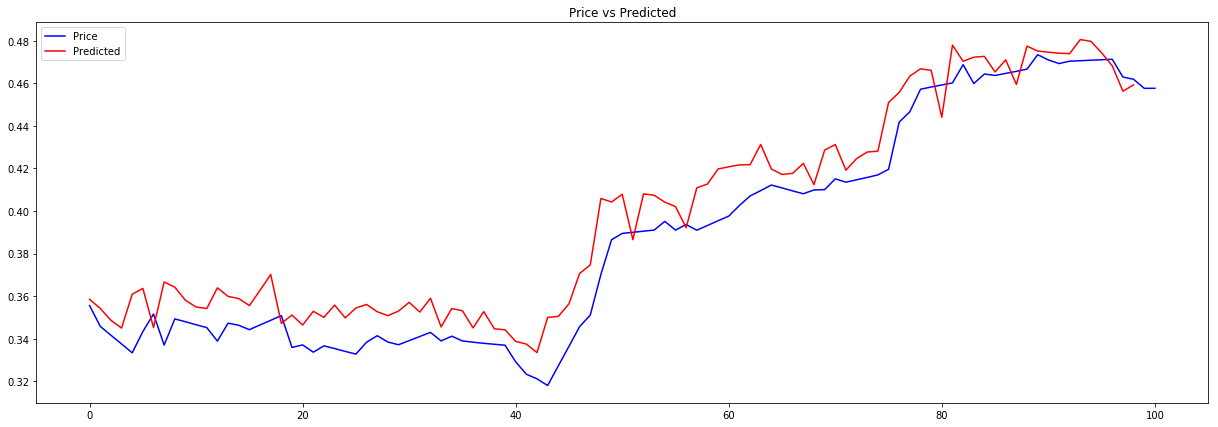

In [104]:
plt.figure(figsize=(21,7))
plt.plot(yTest,label='Price',color='blue')
plt.plot(test_pred_list,label='Predicted',color='red')
plt.title('Price vs Predicted')
plt.legend(loc='upper left')
plt.show()

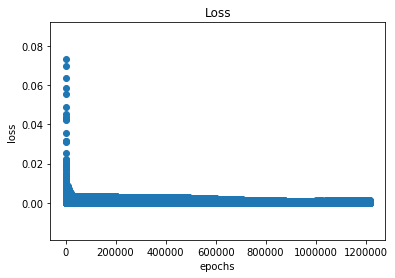

In [105]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.title('Loss')
plt.scatter(x=np.arange(0,len(loss_list)), y=loss_list)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()